# PART 2:  Understanding model order and overfitting

In [110]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


def generate_data_numpy(N, func, noise_std=np.sqrt(0.1)):
    x = np.sort(np.random.rand(N))
    e = np.random.normal(0, noise_std, N)
    t = func(x) + e
    return x.reshape(-1, 1), t.reshape(-1, 1)

In [111]:
def split_data_numpy(X_all, t_all, test_size_ratio, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    N_total = X_all.shape[0]
    indices = np.arange(N_total)
    np.random.shuffle(indices)
    N_test = int(N_total * test_size_ratio)
    test_indices = indices[:N_test]
    train_indices = indices[N_test:]
    X_train, X_test = X_all[train_indices], X_all[test_indices]
    t_train, t_test = t_all[train_indices], t_all[test_indices]
    return X_train, X_test, t_train, t_test


def create_polynomial_features_numpy(X, degree):
    X_flat = X.flatten()
    Phi = np.power(X_flat[:, np.newaxis], np.arange(degree + 1))
    return Phi

In [112]:
def solve_least_squares_numpy(Phi, t):
    w, _, _, _ = np.linalg.lstsq(Phi, t.ravel(), rcond=None)
    return w.reshape(-1, 1)


def solve_ridge_numpy(Phi, t, lambda_val, regularize_bias):
    N_coeffs = Phi.shape[1]
    penalty_matrix = lambda_val * np.eye(N_coeffs)
    if not regularize_bias and N_coeffs > 0:
        penalty_matrix[0, 0] = 0
    LHS = Phi.T @ Phi + penalty_matrix
    RHS = Phi.T @ t.ravel()
    try:
        if lambda_val < 1e-9 and N_coeffs > Phi.shape[0]:
            w = np.linalg.lstsq(LHS, RHS, rcond=None)[0]
        else:
            w = np.linalg.solve(LHS, RHS)
    except np.linalg.LinAlgError:
        w = np.linalg.lstsq(LHS, RHS, rcond=None)[0]
    return w.reshape(-1, 1)


def predict_numpy(Phi, w):
    return Phi @ w


def rmse_numpy(t_true, t_pred):
    return np.sqrt(np.mean((t_true.ravel() - t_pred.ravel()) ** 2))


def original_func_np(x_np):
    return np.sin(2 * np.pi * x_np)


def altered_func_np(x_np):
    return 5 + np.sin(2 * np.pi * x_np)

### Ridge Regression Weight Computation

- This function computes the weights **`w`** for a **Ridge Regression** model, which is a regularized variant of the standard least squares regression.

- Ridge Regression adds a penalty term to the ordinary least squares loss function to prevent overfitting and control model complexity. Specifically, it minimizes the following objective:

$$
\text{Loss} = \|Xw - y\|^2 + \lambda \|w\|^2
$$


- **\( X \)**: Feature matrix (samples × features)  
- **\( y \)**: Target values  
- **\( w \)**: Model weights (including bias if applicable)  
- **λ**: Regularization strength (`lambda_val` in the code)

The added penalty term \( \lambda \|w\|^2 \) shrinks the weights, which helps reduce variance and improve generalization on unseen data.

- **`lambda_val`**:A scalar controlling the strength of the L2 regularization. A higher value imposes more penalty on large weights.

- **`regularize_bias`** *(boolean)*:Determines whether to penalize the bias term (**`w₀`**, i.e., the first element of `w`).  
  - If `False`, the bias term is **excluded** from the penalty.  
  - If `True`, all weights, including the bias, are regularized.


- This function outputs the optimal weights `w` for a Ridge Regression model.
- The `lambda_val` parameter helps balance the trade-off between **bias and variance**.
- The `regularize_bias` flag provides flexibility in whether to shrink the bias term or not.


In [113]:
def run_polynomial_regression_experiment_numpy(
    X_train,
    t_train,
    X_test,
    t_test,
    max_M=9,
    model_type="least_squares",
    ridge_lambda=0.0,
    regularize_bias=False,
    plot_all_individual_M_fits=False,
    X_full_for_plot=None,
    func_for_plot=None,
    scenario_title_prefix="",
):
    train_rmses = []
    test_rmses = []
    Ms_list = list(range(max_M + 1))
    weights_dict = {}

    if plot_all_individual_M_fits and X_full_for_plot is None:
        print(
            "Warning: X_full_for_plot not provided for individual M plotting. Skipping these plots."
        )
        plot_all_individual_M_fits = False

    # Counter for subplot positioning
    plot_counter = 0

    for M_val in Ms_list:
        Phi_train = create_polynomial_features_numpy(X_train, M_val)
        Phi_test = create_polynomial_features_numpy(X_test, M_val)

        if model_type == "least_squares":
            w = solve_least_squares_numpy(Phi_train, t_train)
        elif model_type == "ridge":
            w = solve_ridge_numpy(Phi_train, t_train, ridge_lambda, regularize_bias)
        else:
            raise ValueError("Unknown model_type")

        weights_dict[M_val] = w.copy()

        t_train_pred = predict_numpy(Phi_train, w)
        t_test_pred = predict_numpy(Phi_test, w)

        train_rmses.append(rmse_numpy(t_train, t_train_pred))
        test_rmses.append(rmse_numpy(t_test, t_test_pred))

        if plot_all_individual_M_fits:
            # Create new figure every 2 plots
            if plot_counter % 2 == 0:
                fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Select current subplot
            ax = axes[plot_counter % 2]

            ax.scatter(
                X_train,
                t_train,
                facecolors="none",
                edgecolors="blue",
                s=30,
                label="Training data",
            )
            ax.scatter(
                X_test,
                t_test,
                facecolors="none",
                edgecolors="red",
                s=30,
                label="Testing data",
            )

            x_plot_range_for_true_func = np.linspace(0, 1, 200).reshape(-1, 1)
            if func_for_plot is not None:
                ax.plot(
                    x_plot_range_for_true_func,
                    func_for_plot(x_plot_range_for_true_func.ravel()),
                    "g-",
                    linewidth=2,
                    label="True function",
                )

            Phi_plot = create_polynomial_features_numpy(X_full_for_plot, M_val)
            t_plot_pred_on_full = predict_numpy(Phi_plot, w)
            ax.plot(
                X_full_for_plot,
                t_plot_pred_on_full,
                "m--",
                linewidth=2,
                label=f"Model M={M_val}",
            )

            title_pred = f"{scenario_title_prefix}Fit for M={M_val}"
            if model_type == "ridge":
                title_pred += (
                    f" (Ridge, λ={ridge_lambda:.1e}, bias_reg={regularize_bias})"
                )
            else:
                title_pred += " (Least Squares)"
            ax.set_title(title_pred)
            ax.set_xlabel("x")
            ax.set_ylabel("t")
            ax.legend()

            all_t_values_plot = [t_train.ravel(), t_test.ravel()]
            if func_for_plot is not None:
                all_t_values_plot.append(
                    func_for_plot(x_plot_range_for_true_func.ravel())
                )
            if t_plot_pred_on_full is not None:
                all_t_values_plot.append(t_plot_pred_on_full.ravel())
            all_t_values_plot_flat = np.concatenate(all_t_values_plot)
            min_val_plot, max_val_plot = np.min(all_t_values_plot_flat), np.max(
                all_t_values_plot_flat
            )
            padding = (
                (max_val_plot - min_val_plot) * 0.1
                if (max_val_plot - min_val_plot) > 1e-6
                else 0.1
            )
            ax.set_ylim(min_val_plot - padding, max_val_plot + padding)

            plot_counter += 1

            # Show figure when we have 2 plots or at the end
            if plot_counter % 2 == 0 or M_val == Ms_list[-1]:
                # If last plot is odd, hide the second subplot
                if M_val == Ms_list[-1] and plot_counter % 2 == 1:
                    axes[1].set_visible(False)
                plt.tight_layout()
                plt.show()

    # Overall RMSE plot (keep as single plot since it's a summary)
    plt.figure(figsize=(8, 4))
    plt.plot(Ms_list, train_rmses, "bo-", label="Training RMSE")
    plt.plot(Ms_list, test_rmses, "ro-", label="Testing RMSE")
    plt.xlabel("Model Order M")
    plt.ylabel("RMSE")

    title_rmse = f"{scenario_title_prefix}RMSE vs. Model Order"
    if model_type == "ridge":
        title_rmse += f" (Ridge, λ={ridge_lambda:.1e}, bias_reg={regularize_bias})"
    else:
        title_rmse += " (Least Squares)"
    plt.title(title_rmse)
    plt.legend()
    plt.xticks(Ms_list)
    plt.grid(True)

    combined_rmses = np.array(train_rmses + test_rmses)
    valid_rmses = combined_rmses[np.isfinite(combined_rmses)]
    if len(valid_rmses) > 0:
        max_val_for_ylim = np.max(valid_rmses)
        if (
            len(test_rmses) > 1
            and np.isfinite(test_rmses[0])
            and np.median(np.abs(test_rmses[1:])) > 1e-9
            and test_rmses[0] > 5 * np.median(test_rmses[1:])
        ):
            other_rmses = np.concatenate((train_rmses, test_rmses[1:]))
            valid_other_rmses = other_rmses[np.isfinite(other_rmses)]
            if len(valid_other_rmses) > 0:
                max_val_for_ylim = np.max(valid_other_rmses)
            else:
                max_val_for_ylim = 1.5
        plt.ylim(0, max(1.5, max_val_for_ylim * 1.1))
    else:
        plt.ylim(0, 1.5)
    plt.show()
    return Ms_list, train_rmses, test_rmses, weights_dict

In [114]:
# Helper Function to Report Best M
def report_best_M(
    Ms_list, test_rmses_list, train_rmses_list, weights_dict, scenario_name=""
):
    print(f"\n--- Best Model for {scenario_name} ---")
    if not test_rmses_list or not np.any(np.isfinite(test_rmses_list)):
        print("No valid test RMSEs to analyze or all are non-finite.")
        return -1, float("nan")
    finite_test_rmses = np.array(test_rmses_list)
    finite_indices = np.isfinite(finite_test_rmses)
    if not np.any(finite_indices):
        print("All test RMSEs are non-finite. Cannot determine best M.")
        return -1, float("nan")
    min_test_rmse = np.min(finite_test_rmses[finite_indices])
    best_M_idx_candidates = np.where(np.isclose(test_rmses_list, min_test_rmse))[0]
    if len(best_M_idx_candidates) == 0:
        print("Error finding best M index.")
        return -1, float("nan")
    best_M_idx = best_M_idx_candidates[0]
    best_M_val = Ms_list[best_M_idx]
    best_M_train_rmse_val = train_rmses_list[best_M_idx]
    best_M_w0_val = float("nan")
    if (
        weights_dict
        and best_M_val in weights_dict
        and weights_dict[best_M_val].size > 0
    ):
        best_M_w0_val = weights_dict[best_M_val][0, 0]
    print(f"Best Model Order M: {best_M_val}")
    print(f"  - Minimum Test RMSE:  {min_test_rmse:.4f}")
    print(f"  - Train RMSE at M={best_M_val}: {best_M_train_rmse_val:.4f}")
    if np.isfinite(best_M_w0_val):
        print(f"  - Bias w0 at M={best_M_val}:   {best_M_w0_val:.4f}")
    print("--- End Best Model Report ---")
    return best_M_val, min_test_rmse

- This function finds the model order M that achieved the lowest test RMSE.

In [115]:
# Part (a): Generate 20 data points and partitioning
N_total_a = 20
np.random.seed(42)
X_all_a, t_all_a = generate_data_numpy(
    N_total_a, original_func_np, noise_std=np.sqrt(0.1)
)
X_train_a10, X_test_a10, t_train_a10, t_test_a10 = split_data_numpy(
    X_all_a, t_all_a, test_size_ratio=0.5, random_state=42
)

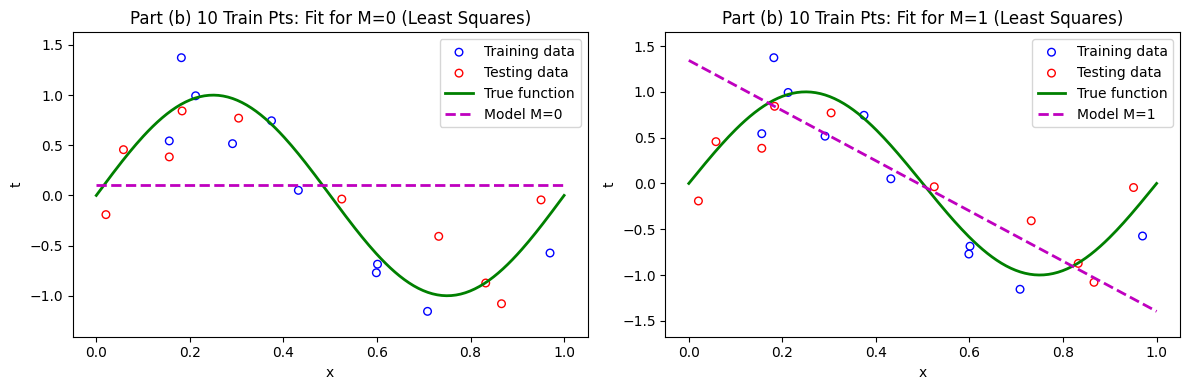

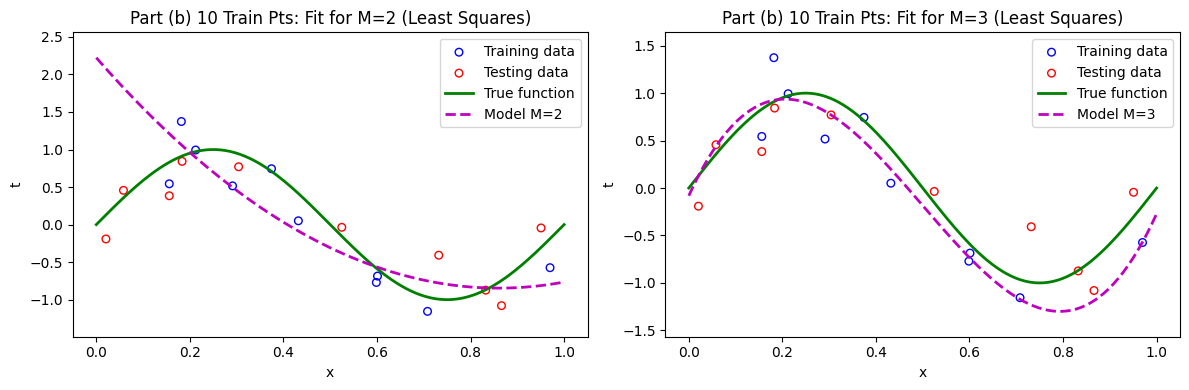

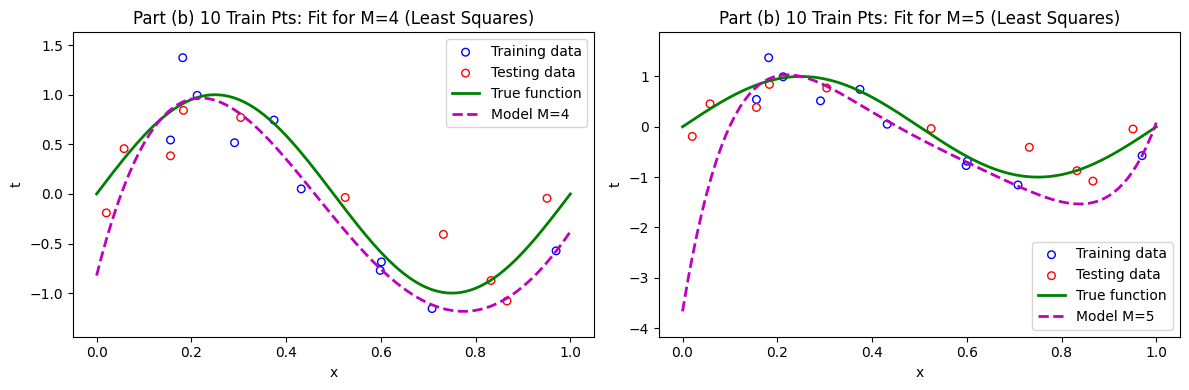

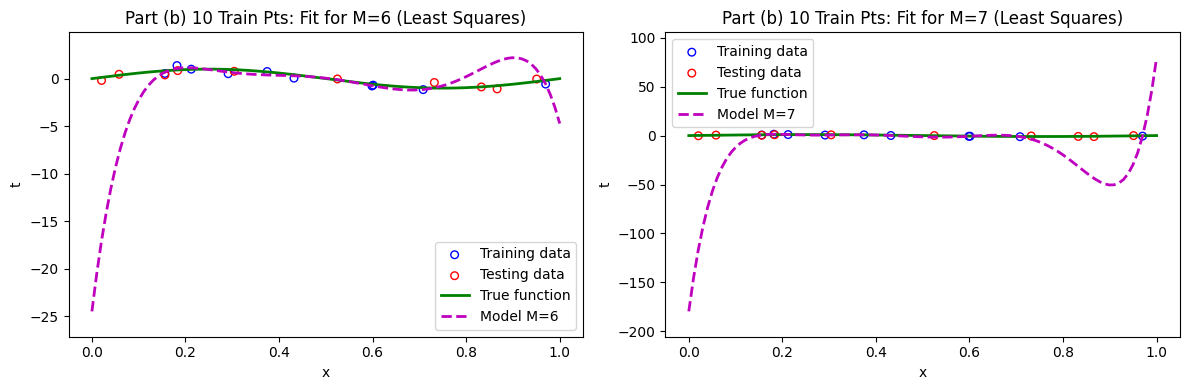

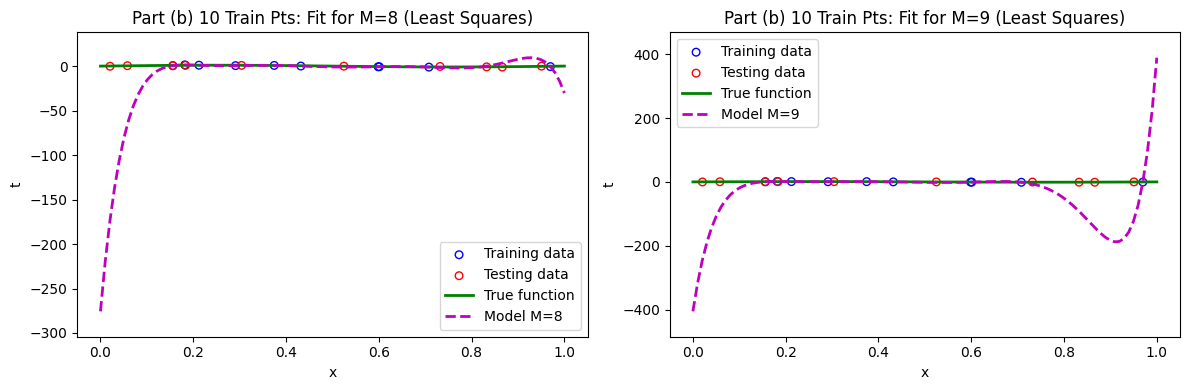

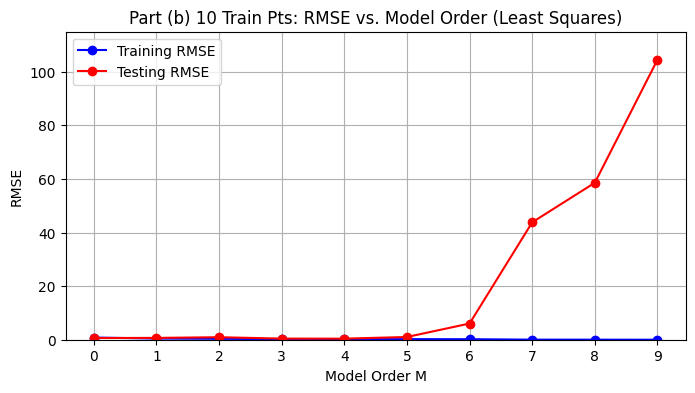


--- Best Model for Part (b) 10 Train Pts:  ---
Best Model Order M: 4
  - Minimum Test RMSE:  0.3999
  - Train RMSE at M=4: 0.2212
  - Bias w0 at M=4:   -0.8228
--- End Best Model Report ---


(4, np.float64(0.3998554793843465))

In [116]:
# (b): Fit M-th degree polynomial and evaluate
x_plot_range_b = np.linspace(0, 1, 100).reshape(-1, 1)
scenario_b_title = "Part (b) 10 Train Pts: "

Ms_b, train_rmses_b, test_rmses_b, weights_b = (
    run_polynomial_regression_experiment_numpy(
        X_train_a10,
        t_train_a10,
        X_test_a10,
        t_test_a10,
        max_M=9,
        model_type="least_squares",
        plot_all_individual_M_fits=True,
        X_full_for_plot=x_plot_range_b,
        func_for_plot=original_func_np,
        scenario_title_prefix=scenario_b_title,
    )
)
report_best_M(Ms_b, test_rmses_b, train_rmses_b, weights_b, scenario_b_title)

### OverFitting vs UnderFitting Observations

- ```UnderFitting```: This happens when the model is not complex enough to capture the underlying pattern in the data.
    - This will be evident for low values of M, such as M=0, M=1, or M=2. A polynomial of degree 0 is a horizontal line, and a degree 1 is a straight diagonal line.
    - The fitted magenta line (---) will be a straight line that tries its best to cut through the curvy sine wave data. It will clearly fail to capture the wave's shape.
    - For low M, both the Training RMSE (blue line) and the Test RMSE (red line) will be high. The model performs poorly even on the data it was trained on because it simply lacks the capacity to represent the true function.

- ```OverFitting```: It happens when the model is so complex that it starts fitting the random noise in the training data, rather than just the underlying pattern.
    - For high values of M, like M=9, the model has 10 coefficients (w0 to w9) to fit 10 data points. It has enough flexibility to wiggle wildly to pass through every single training point perfectly.
    - The Training RMSE (blue line) will be extremely low (approaching zero).
    - The Test RMSE (red line) will be extremely high.
    - There will be a large gap between the training and test error as shown with red and blue line in the plot.


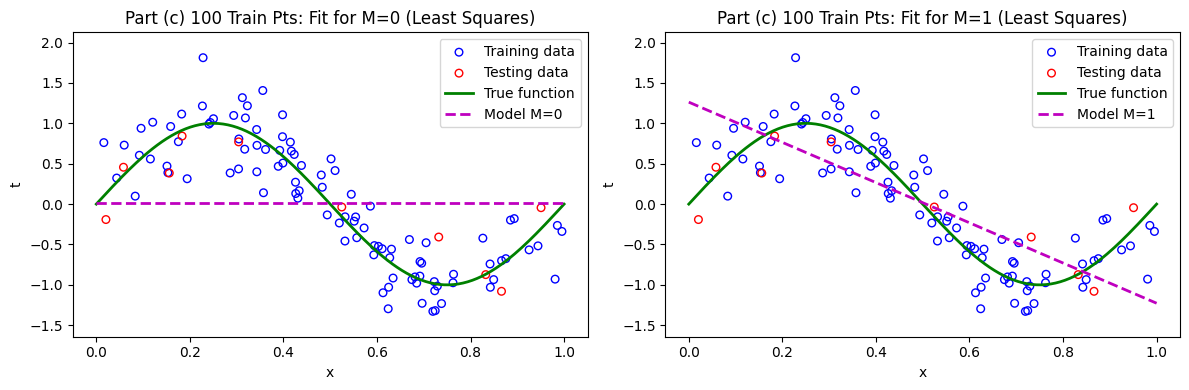

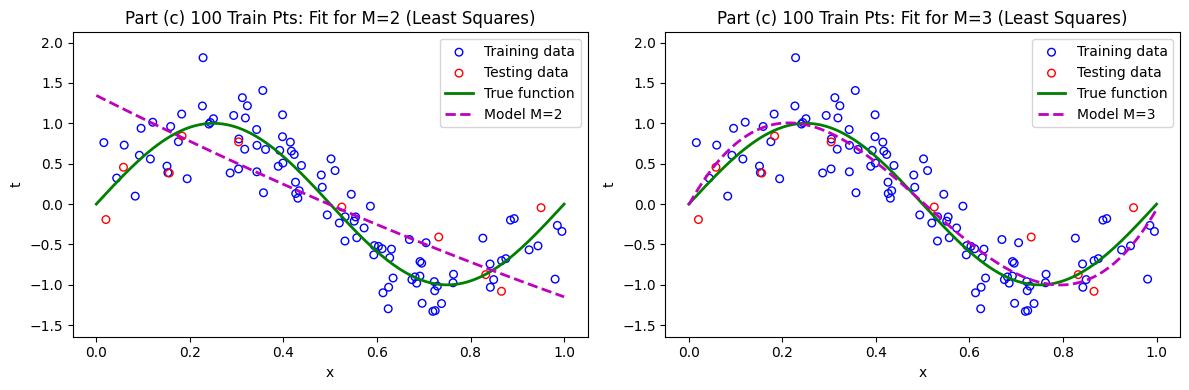

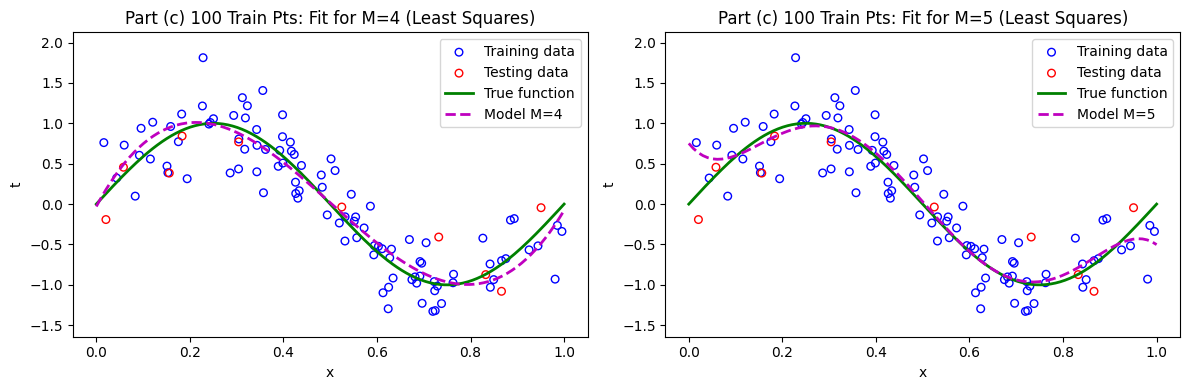

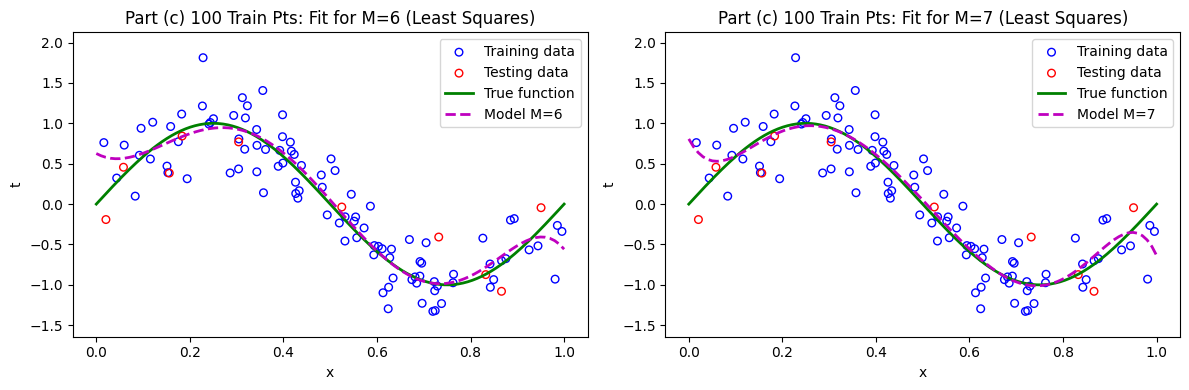

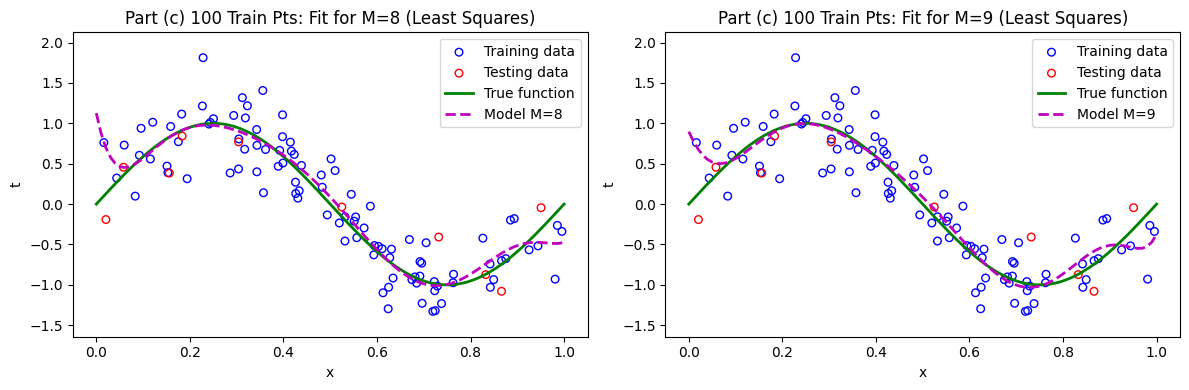

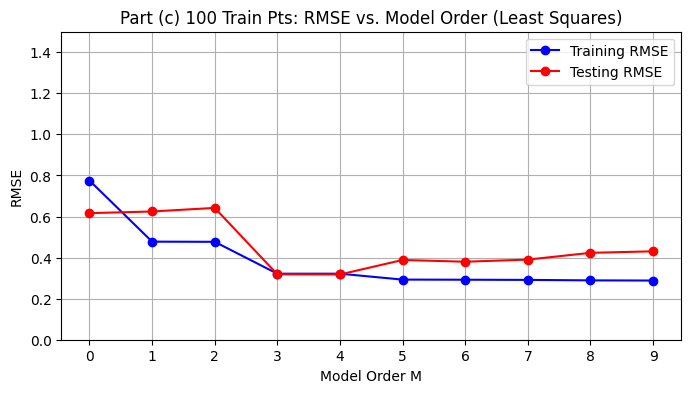


--- Best Model for Part (c) 100 Train Pts:  ---
Best Model Order M: 4
  - Minimum Test RMSE:  0.3179
  - Train RMSE at M=4: 0.3215
  - Bias w0 at M=4:   -0.0296
--- End Best Model Report ---


(4, np.float64(0.3178597261230379))

In [117]:
# Part (c): Expand training dataset to 100 points, repeat (b)
N_train_c100 = 100
np.random.seed(123)
X_train_c100, t_train_c100 = generate_data_numpy(
    N_train_c100, original_func_np, noise_std=np.sqrt(0.1)
)
x_plot_range_c = np.linspace(0, 1, 100).reshape(-1, 1)
scenario_c_title = "Part (c) 100 Train Pts: "

Ms_c, train_rmses_c, test_rmses_c, weights_c = (
    run_polynomial_regression_experiment_numpy(
        X_train_c100,
        t_train_c100,
        X_test_a10,
        t_test_a10,
        max_M=9,
        model_type="least_squares",
        plot_all_individual_M_fits=True,
        X_full_for_plot=x_plot_range_c,
        func_for_plot=original_func_np,
        scenario_title_prefix=scenario_c_title,
    )
)
report_best_M(Ms_c, test_rmses_c, train_rmses_c, weights_c, scenario_c_title)


--- Part (d): L2 Regularization (Ridge Regression, NumPy) ---

 Regularization with 10 training points 

Analyzing for Part (d) 10 Train Pts λ=0e+00: :


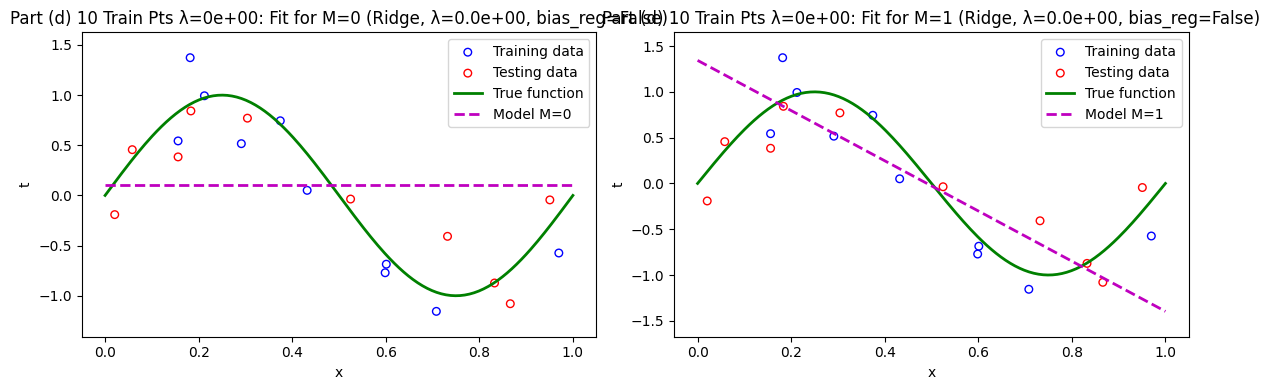

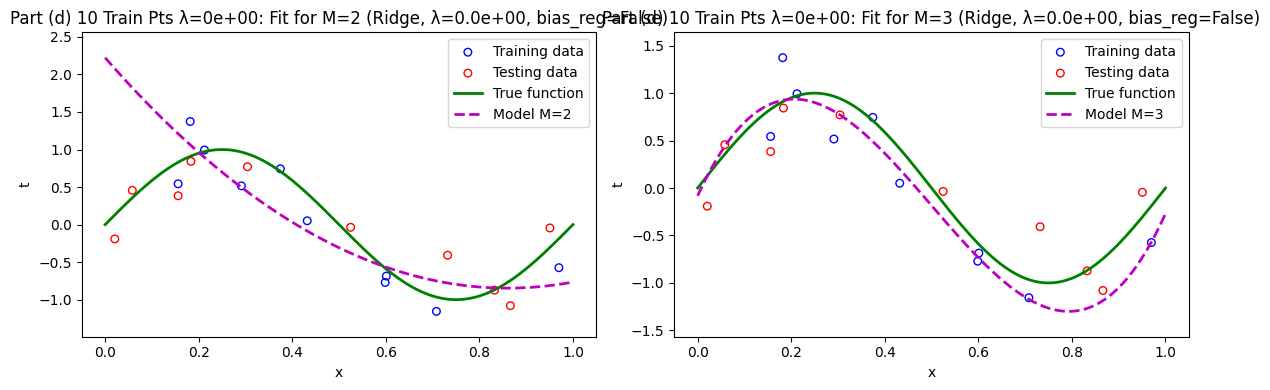

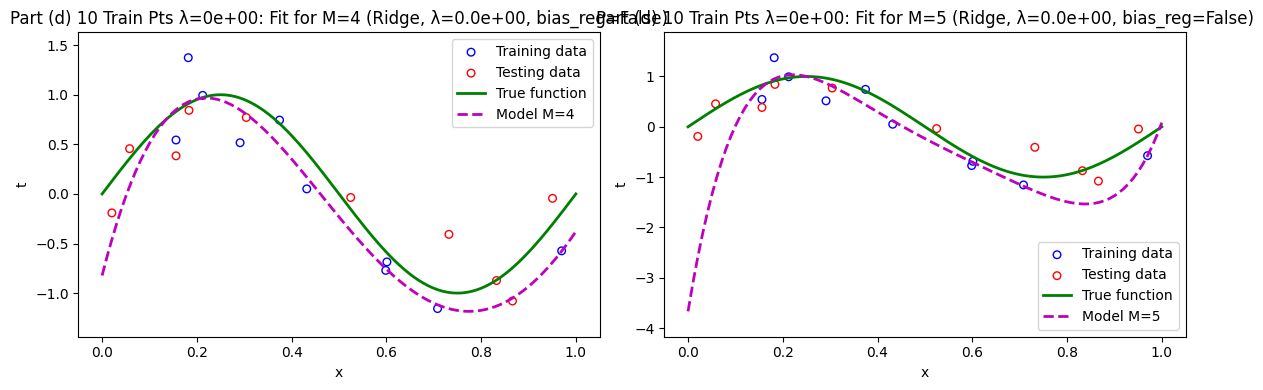

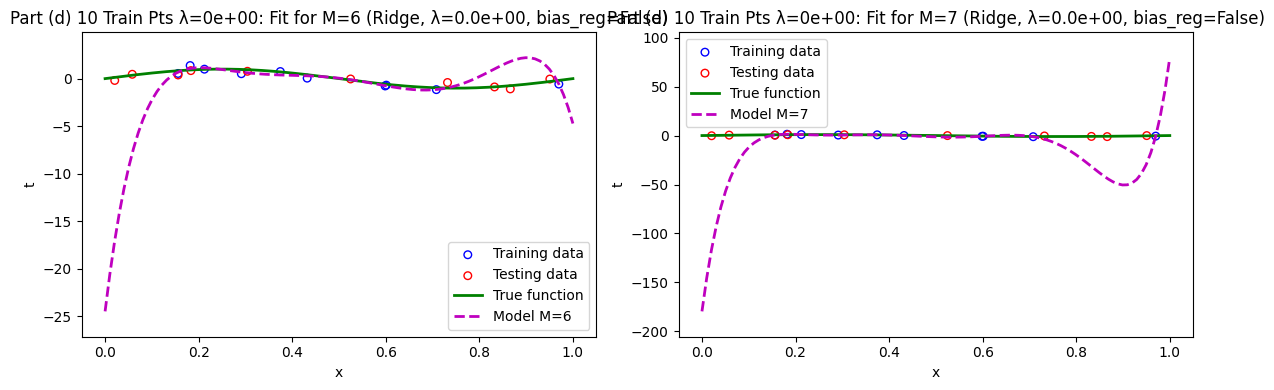

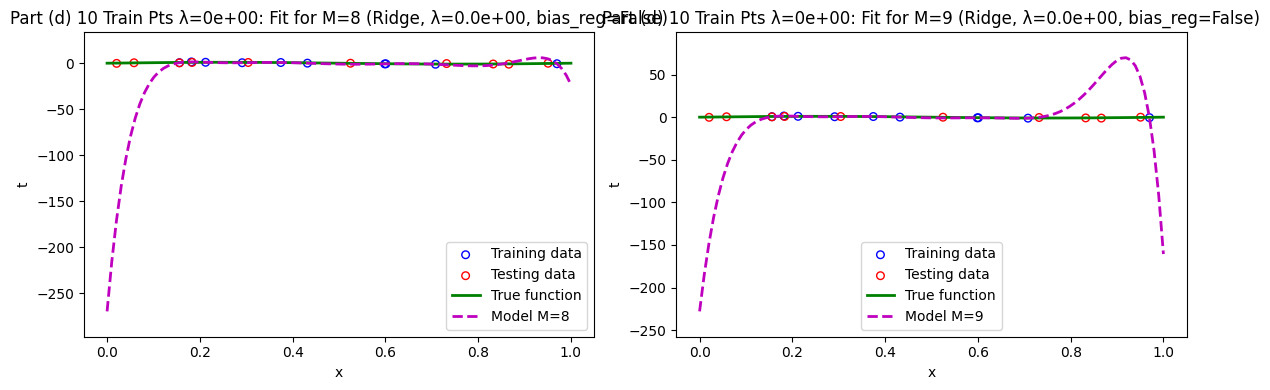

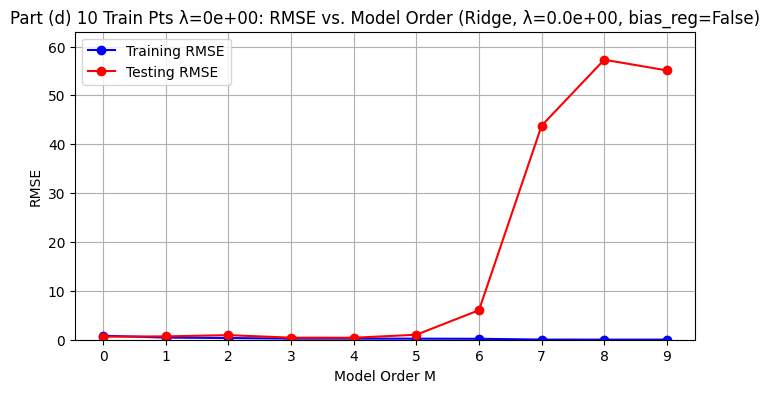


--- Best Model for Part (d) 10 Train Pts λ=0e+00:  ---
Best Model Order M: 4
  - Minimum Test RMSE:  0.3999
  - Train RMSE at M=4: 0.2212
  - Bias w0 at M=4:   -0.8228
--- End Best Model Report ---

Analyzing for Part (d) 10 Train Pts λ=1e-06: :


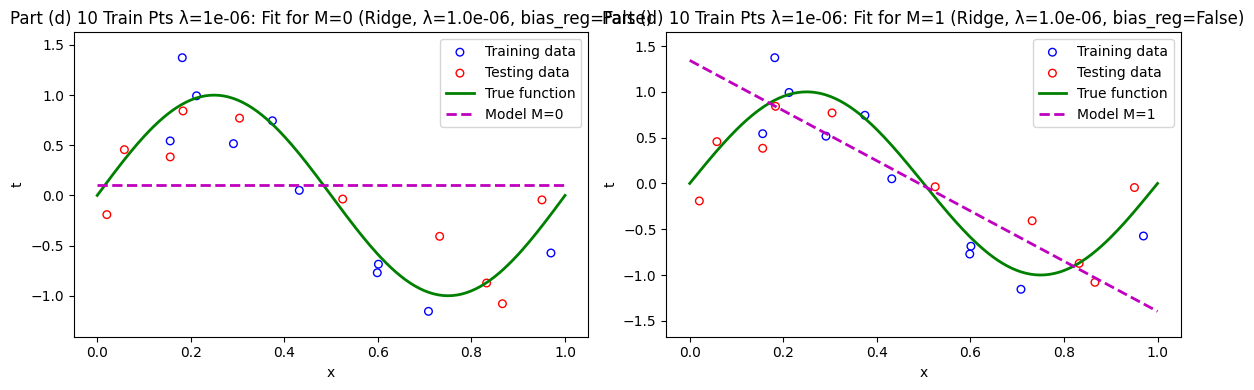

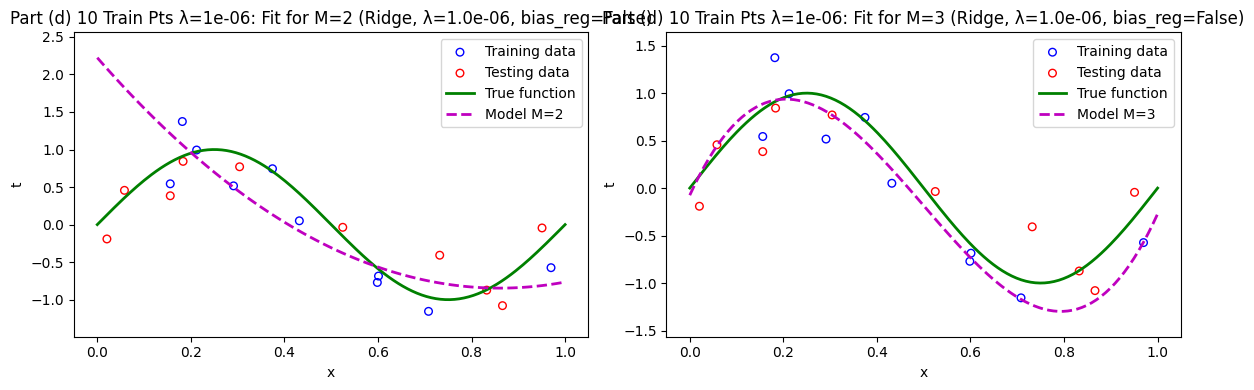

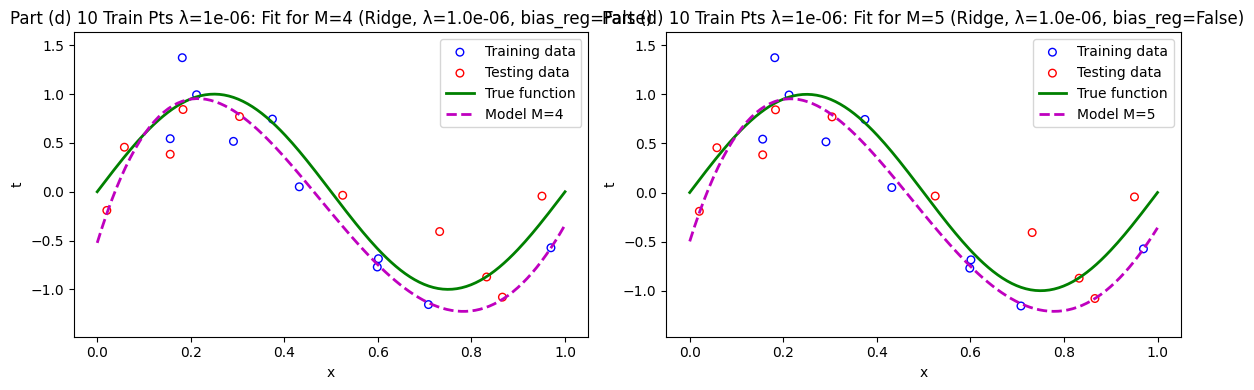

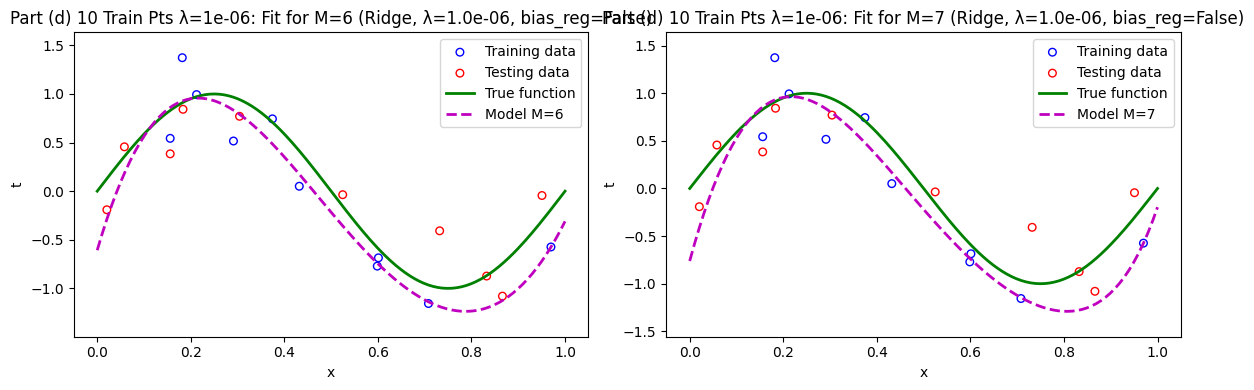

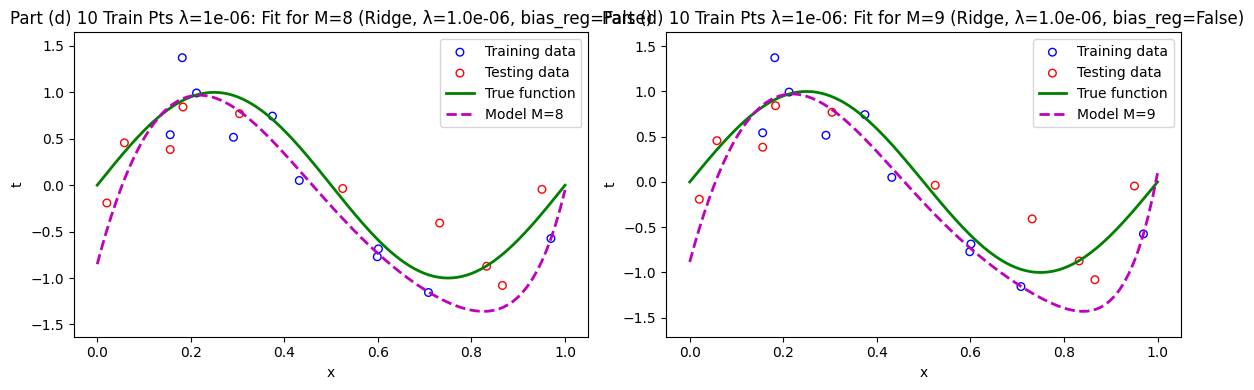

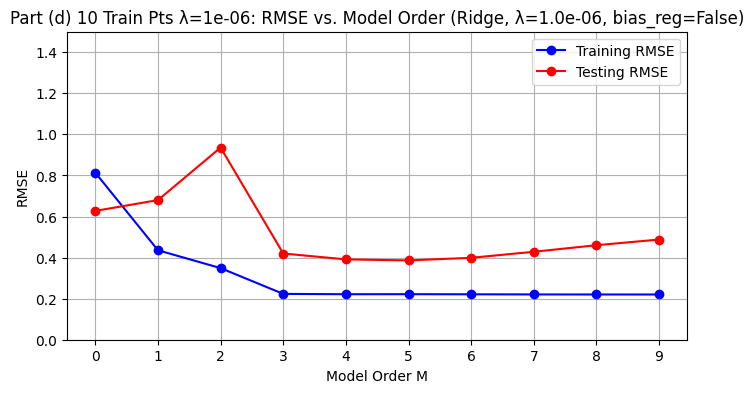


--- Best Model for Part (d) 10 Train Pts λ=1e-06:  ---
Best Model Order M: 5
  - Minimum Test RMSE:  0.3863
  - Train RMSE at M=5: 0.2217
  - Bias w0 at M=5:   -0.4978
--- End Best Model Report ---

Analyzing for Part (d) 10 Train Pts λ=1e-03: :


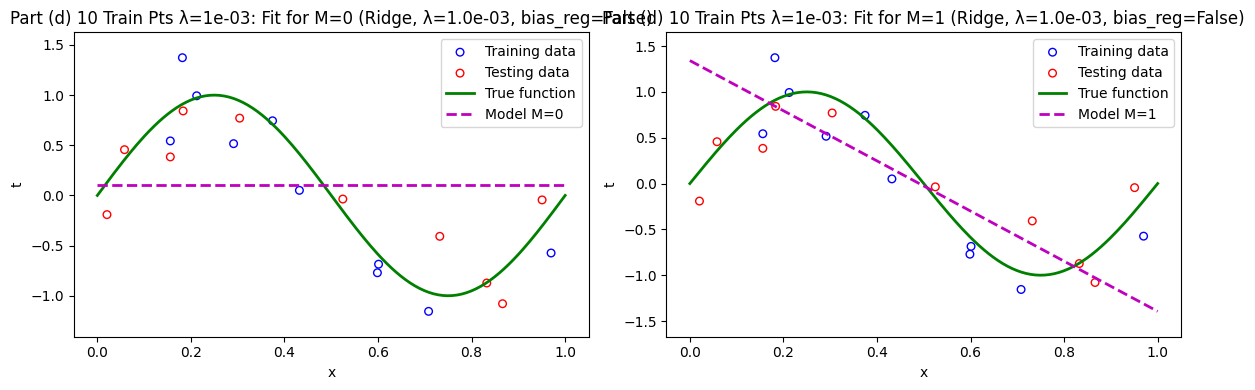

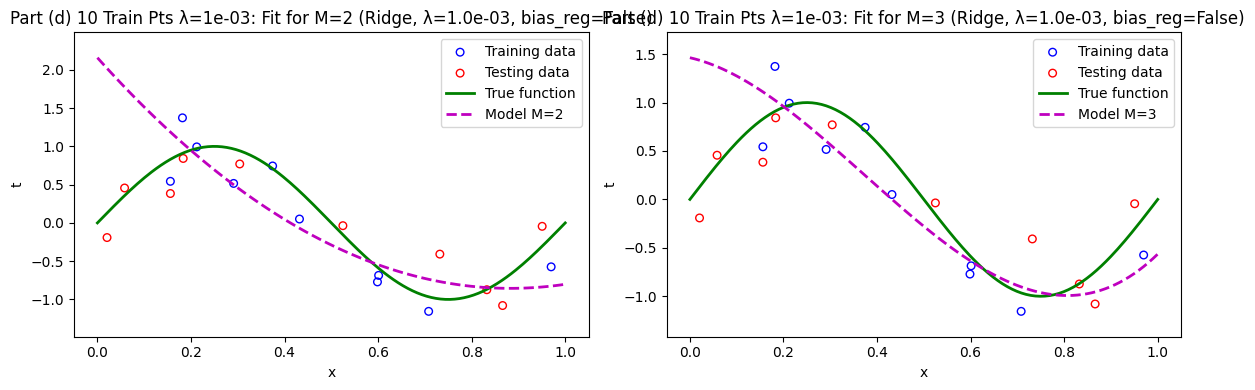

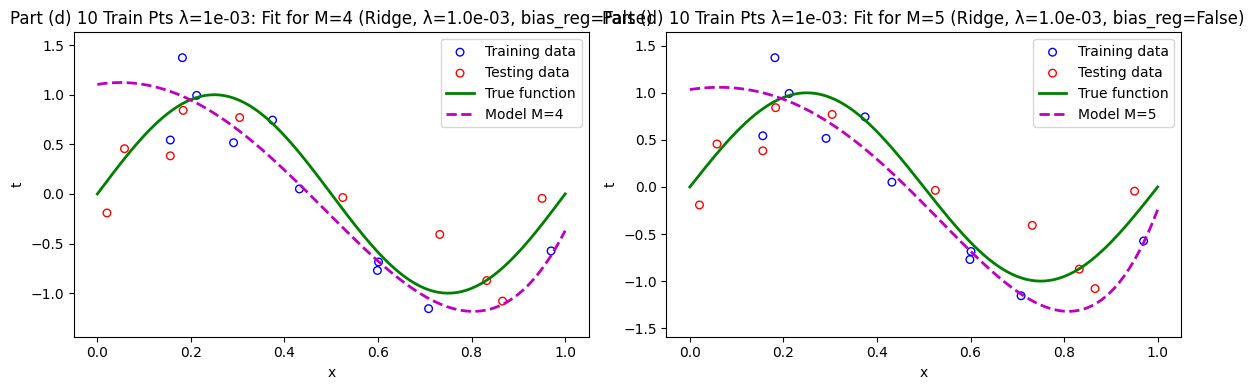

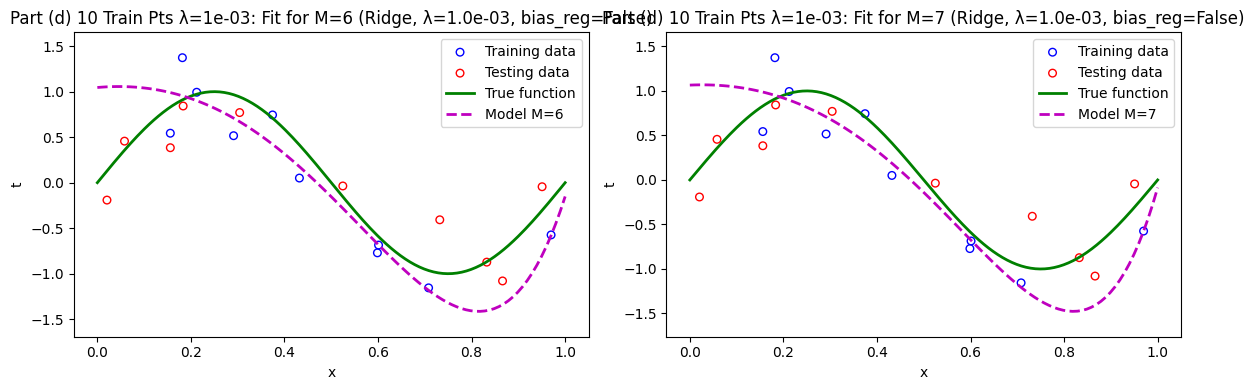

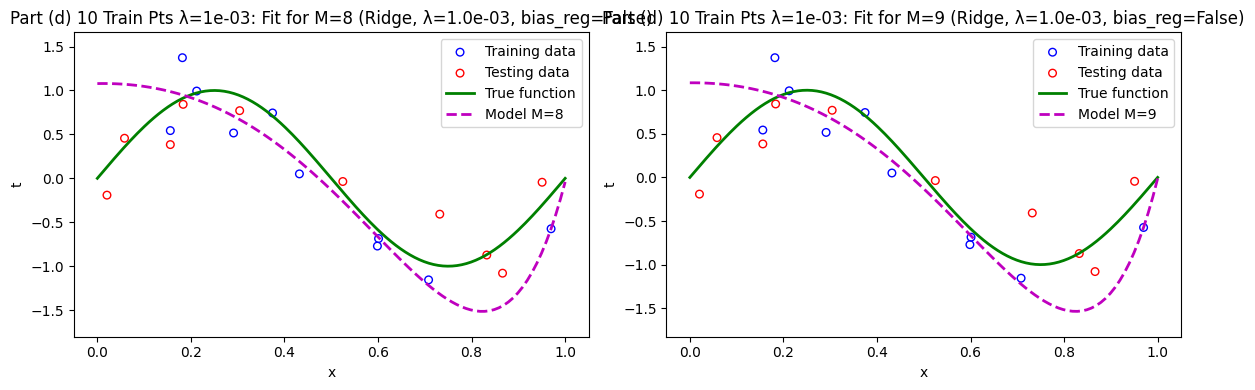

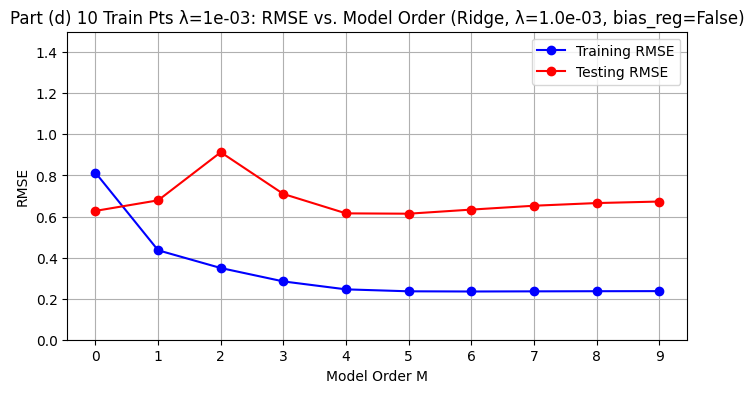


--- Best Model for Part (d) 10 Train Pts λ=1e-03:  ---
Best Model Order M: 5
  - Minimum Test RMSE:  0.6137
  - Train RMSE at M=5: 0.2358
  - Bias w0 at M=5:   1.0347
--- End Best Model Report ---

Analyzing for Part (d) 10 Train Pts λ=1e-01: :


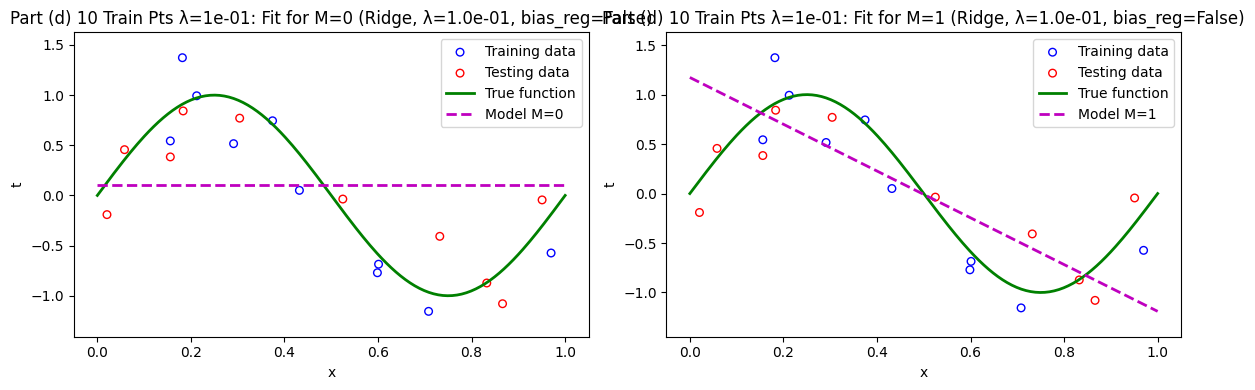

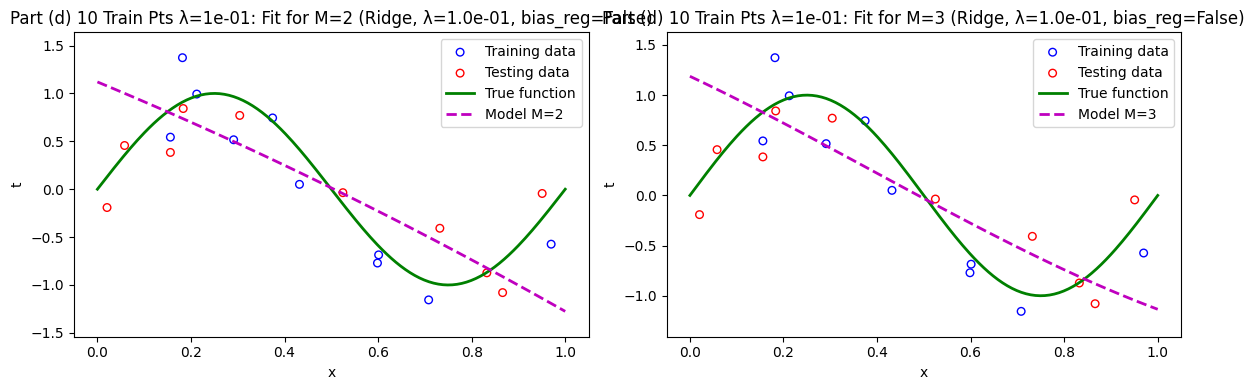

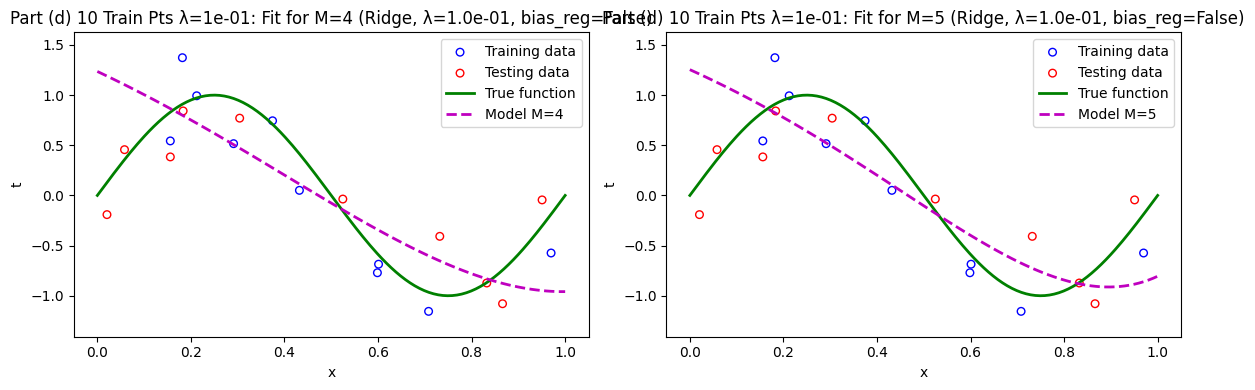

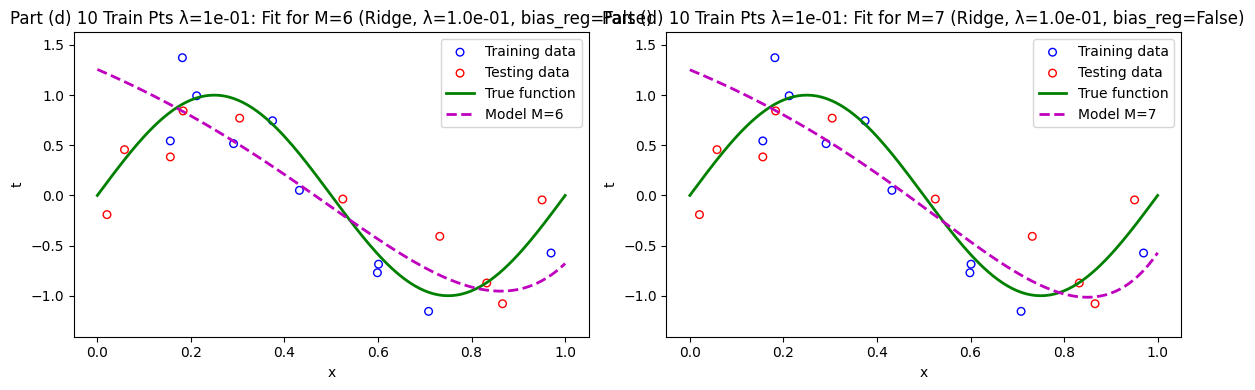

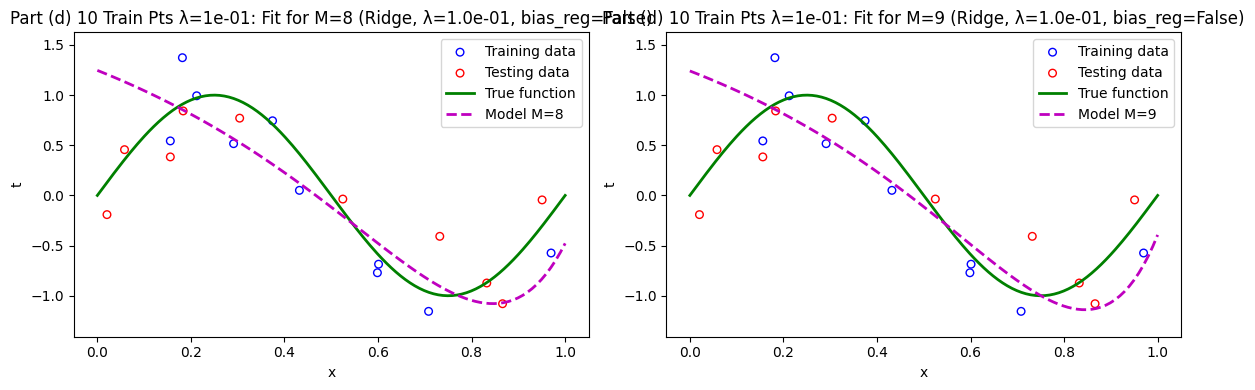

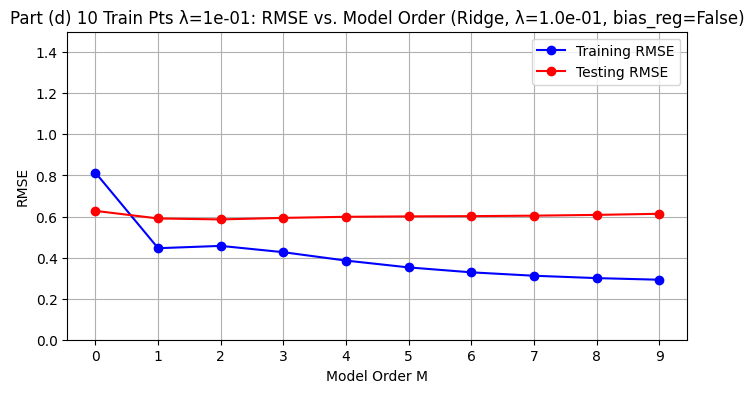


--- Best Model for Part (d) 10 Train Pts λ=1e-01:  ---
Best Model Order M: 2
  - Minimum Test RMSE:  0.5860
  - Train RMSE at M=2: 0.4570
  - Bias w0 at M=2:   1.1200
--- End Best Model Report ---

Regularization with 100 training points

Analyzing for Part (d) 100 Train Pts λ=0e+00: :


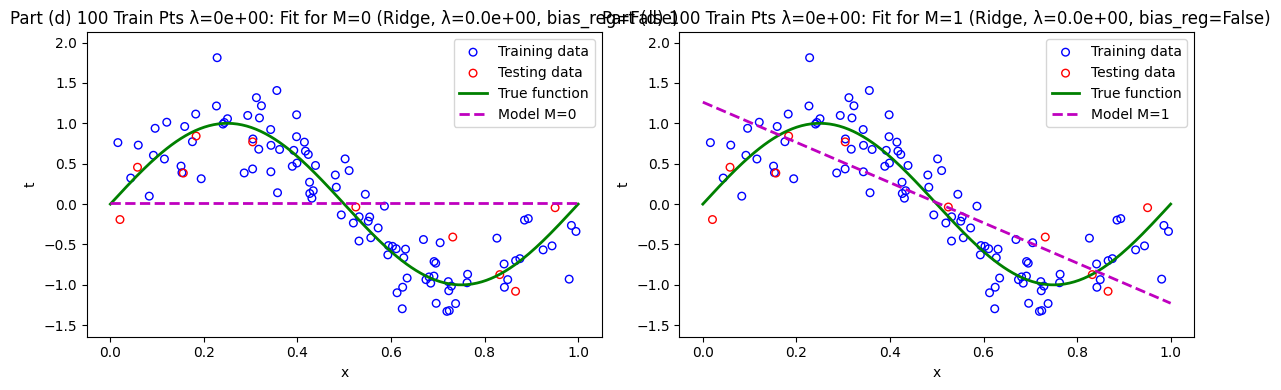

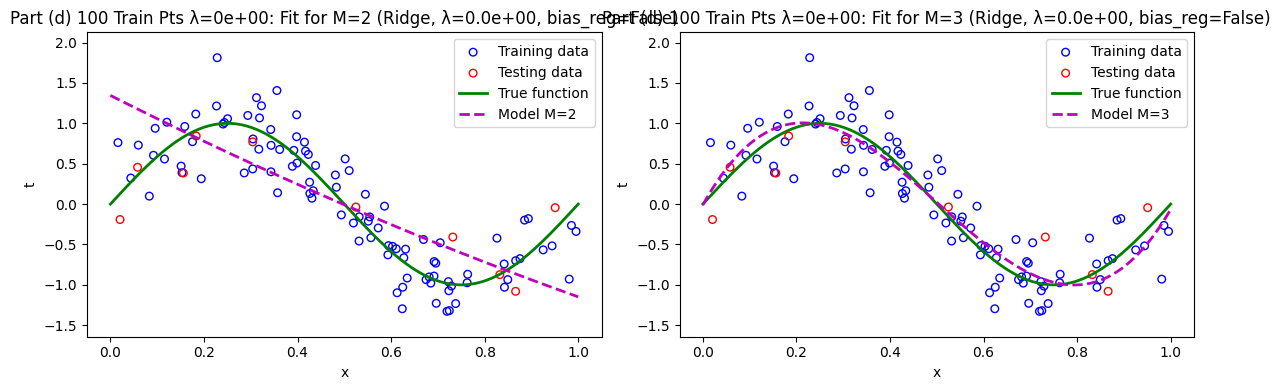

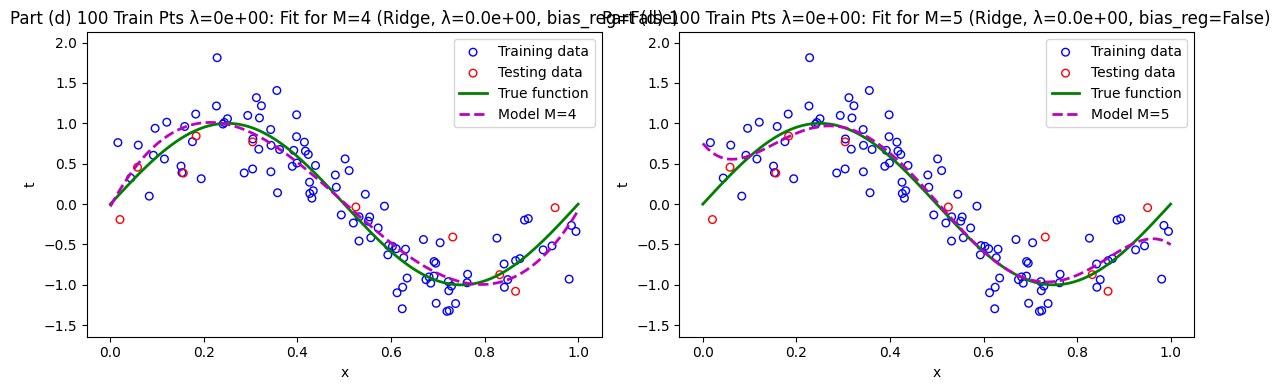

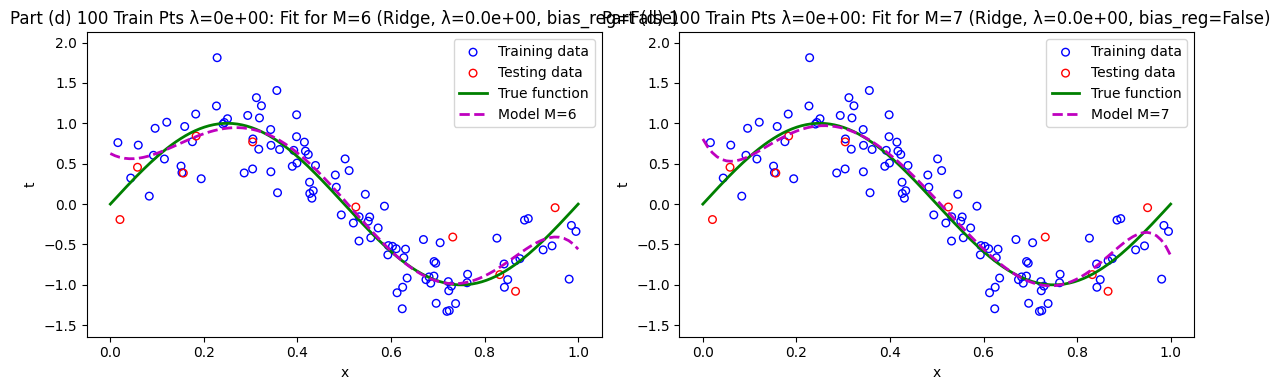

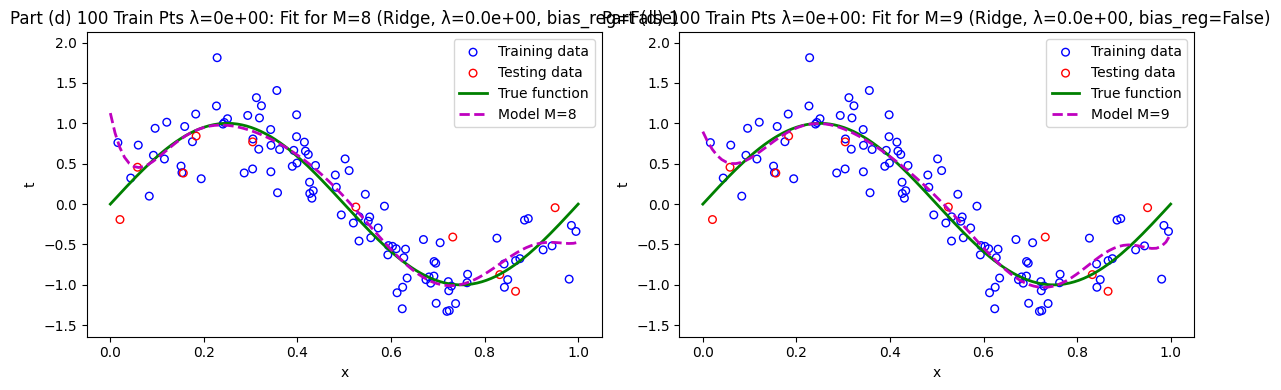

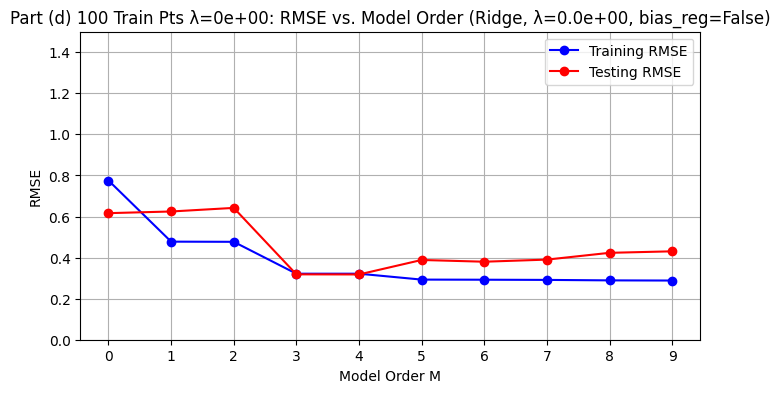


--- Best Model for Part (d) 100 Train Pts λ=0e+00:  ---
Best Model Order M: 4
  - Minimum Test RMSE:  0.3179
  - Train RMSE at M=4: 0.3215
  - Bias w0 at M=4:   -0.0296
--- End Best Model Report ---

Analyzing for Part (d) 100 Train Pts λ=1e-06: :


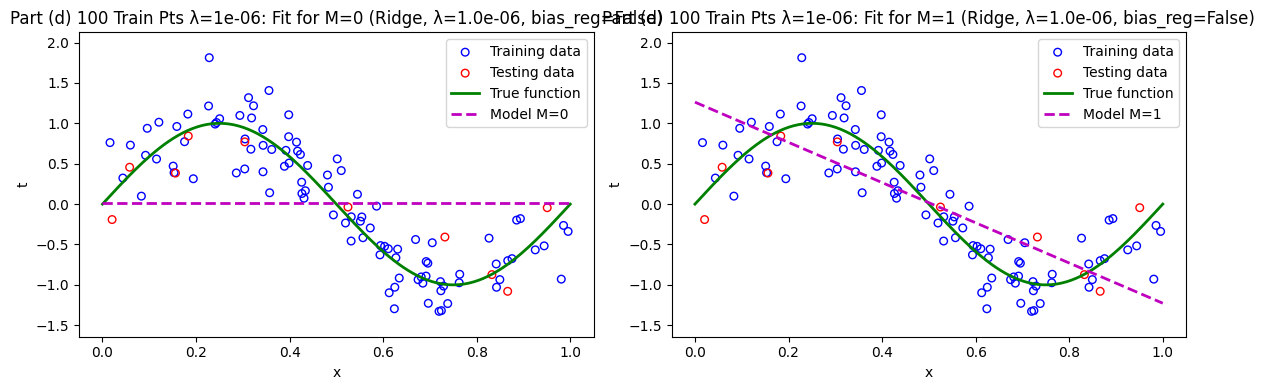

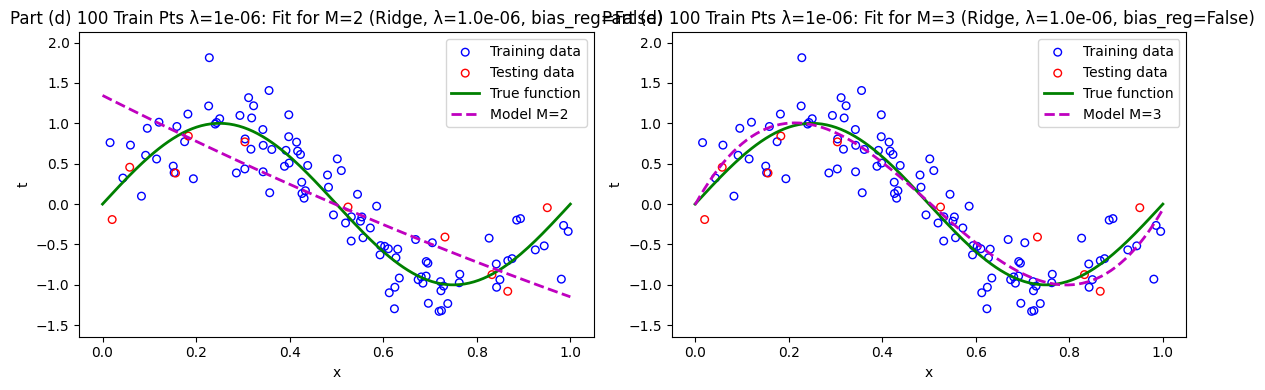

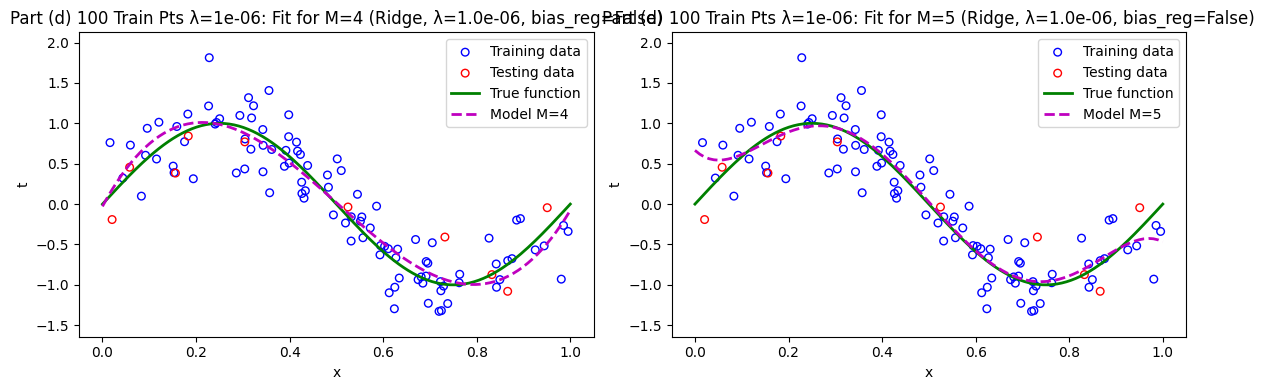

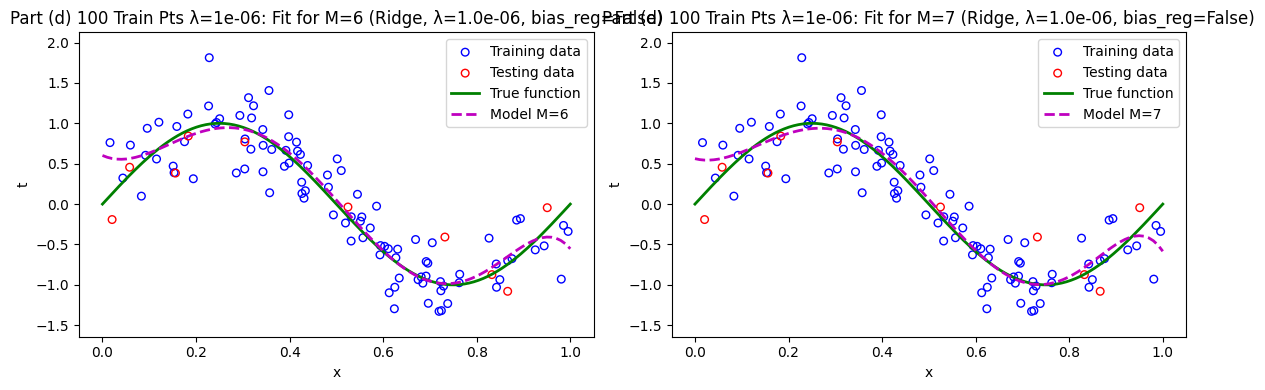

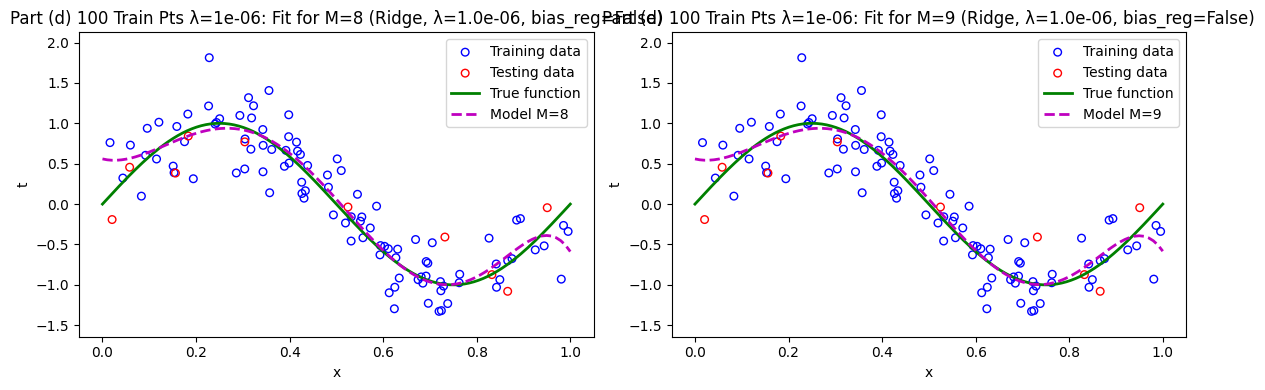

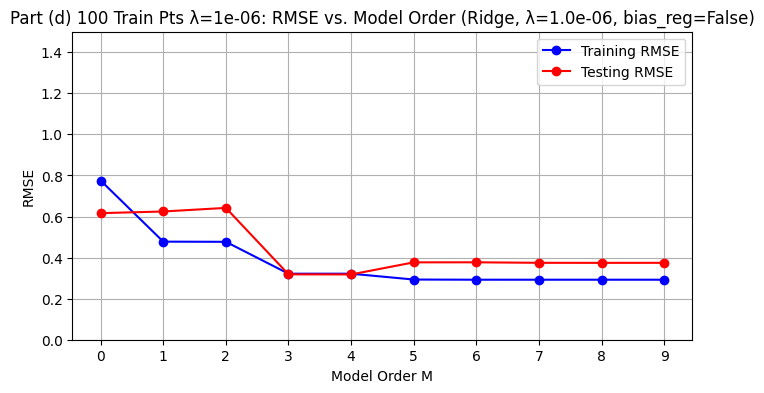


--- Best Model for Part (d) 100 Train Pts λ=1e-06:  ---
Best Model Order M: 4
  - Minimum Test RMSE:  0.3179
  - Train RMSE at M=4: 0.3215
  - Bias w0 at M=4:   -0.0283
--- End Best Model Report ---

Analyzing for Part (d) 100 Train Pts λ=1e-03: :


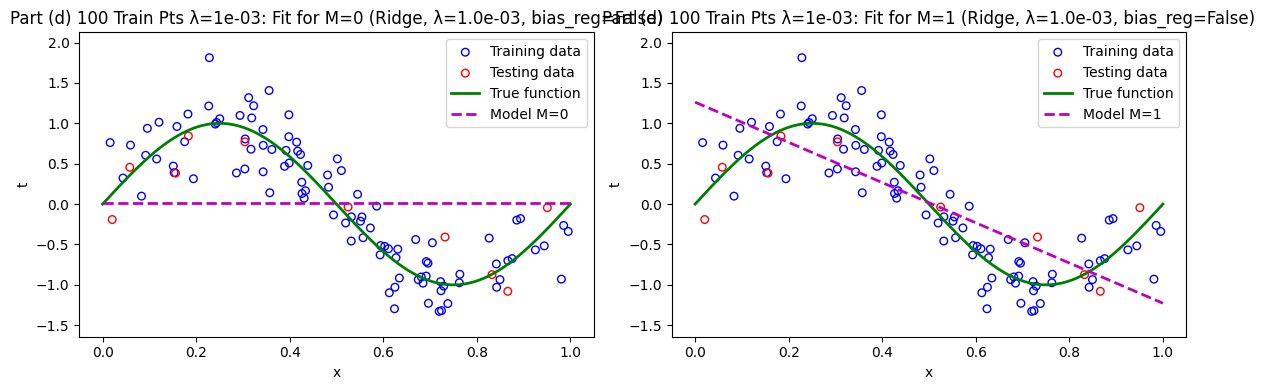

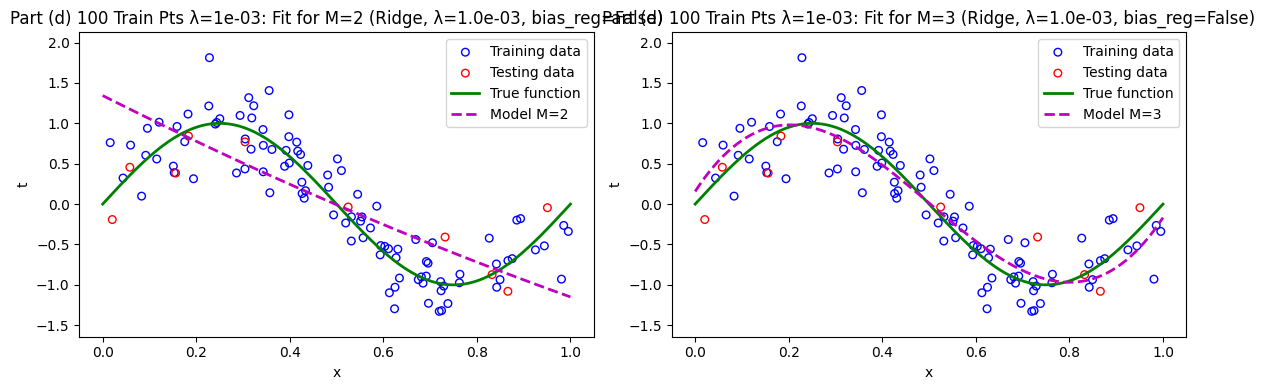

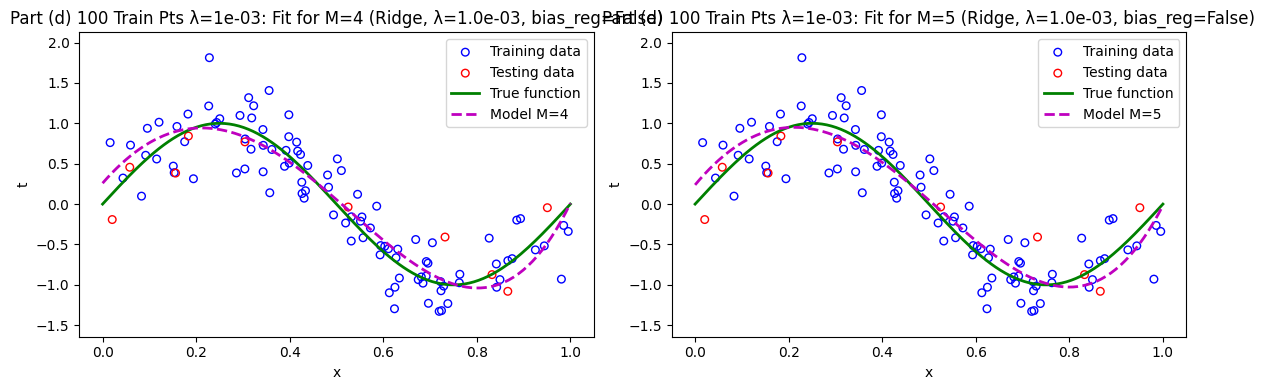

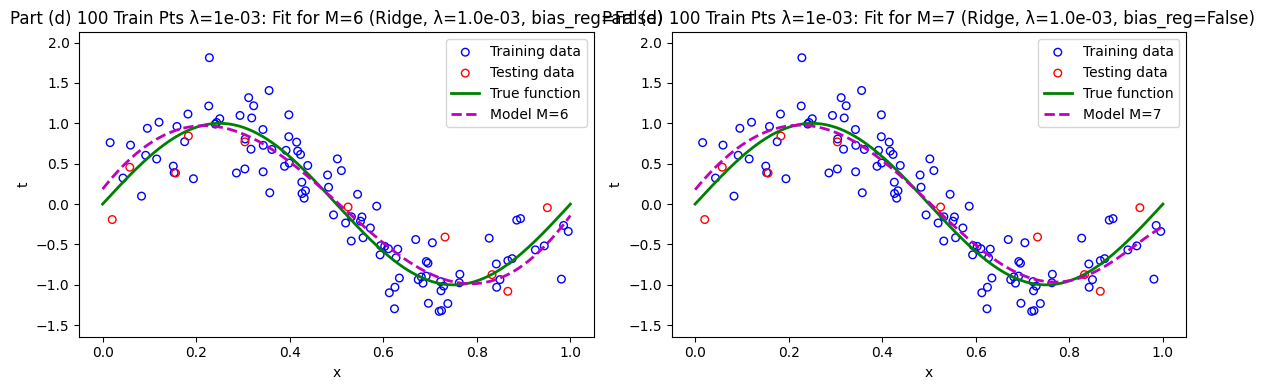

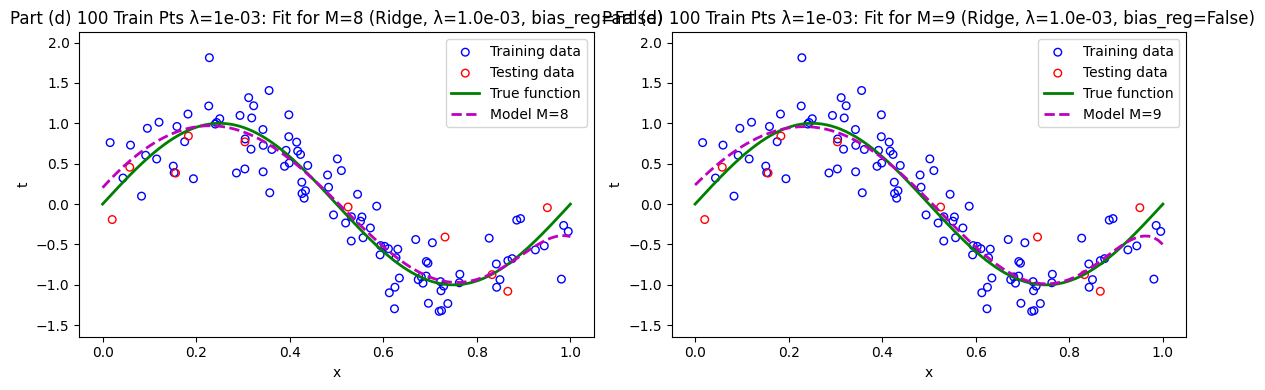

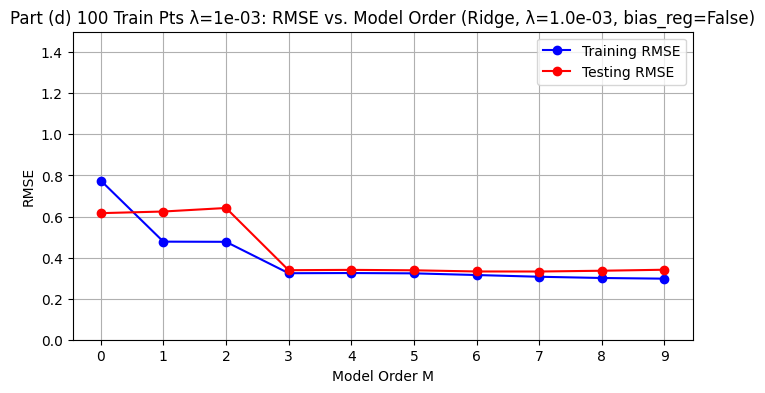


--- Best Model for Part (d) 100 Train Pts λ=1e-03:  ---
Best Model Order M: 7
  - Minimum Test RMSE:  0.3322
  - Train RMSE at M=7: 0.3067
  - Bias w0 at M=7:   0.1776
--- End Best Model Report ---

Analyzing for Part (d) 100 Train Pts λ=1e-01: :


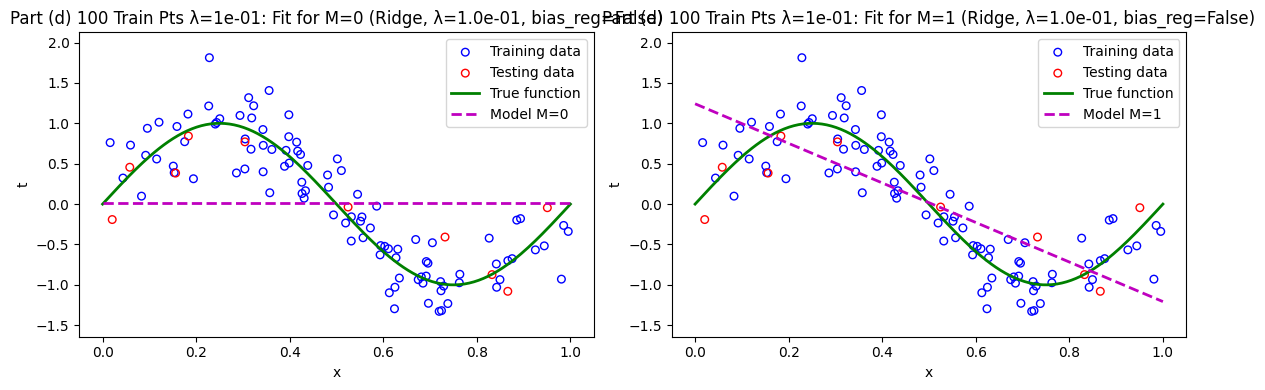

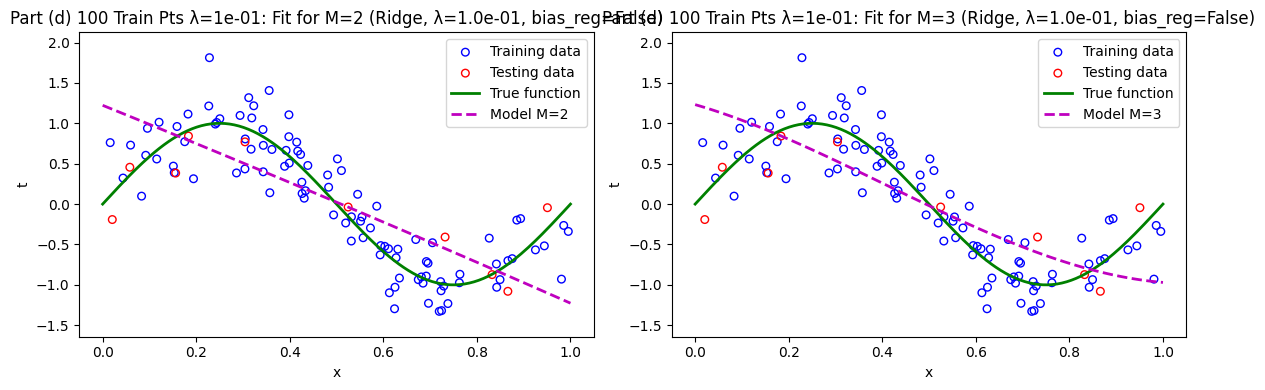

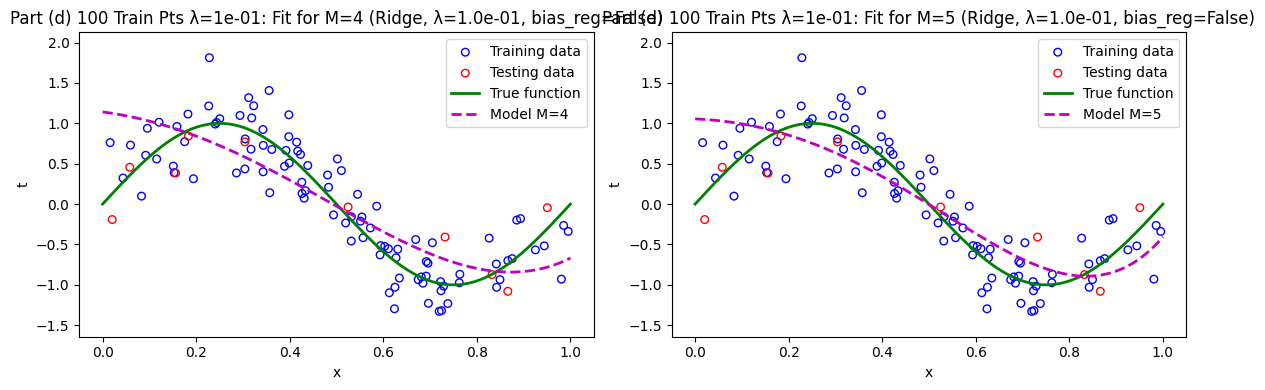

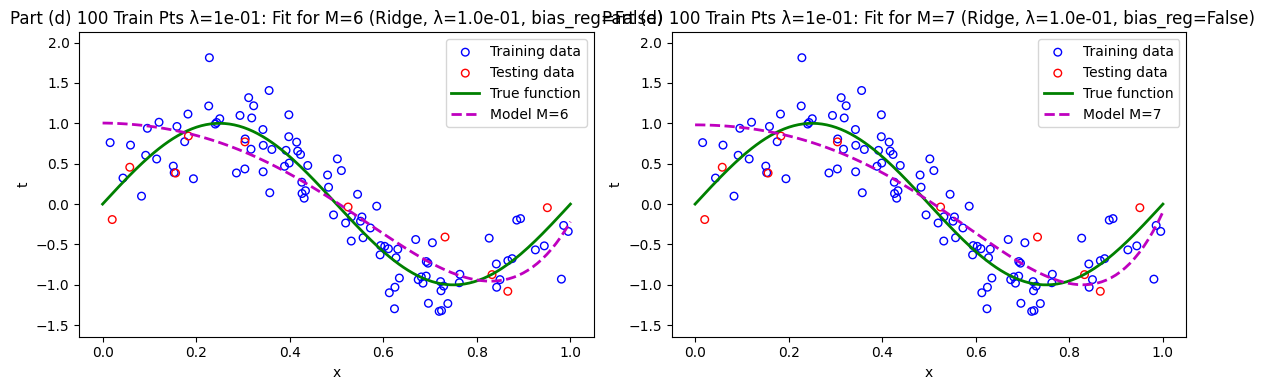

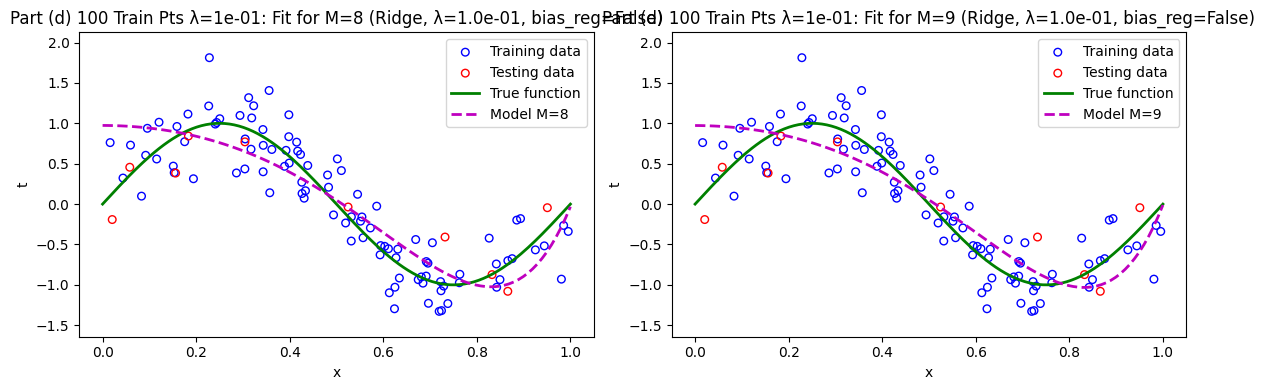

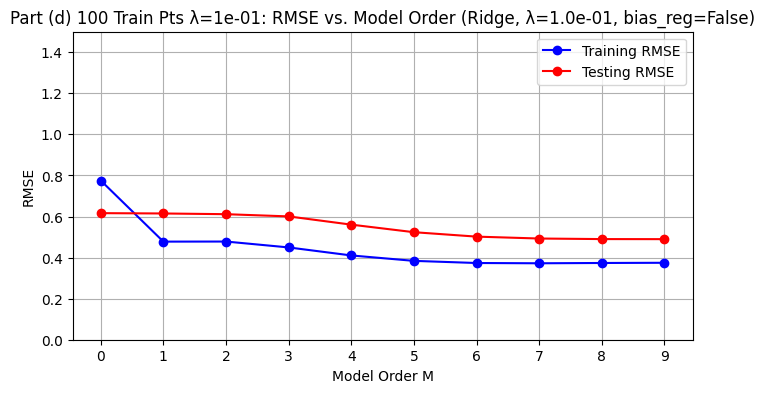


--- Best Model for Part (d) 100 Train Pts λ=1e-01:  ---
Best Model Order M: 9
  - Minimum Test RMSE:  0.4898
  - Train RMSE at M=9: 0.3747
  - Bias w0 at M=9:   0.9728
--- End Best Model Report ---


In [118]:
# Part (d): L2 regularization (Ridge) and repeat (b) and (c) 
print("\n--- Part (d): L2 Regularization (Ridge Regression, NumPy) ---")
lambda_values_d = [
    0,
    1e-6,
    1e-3,
    1e-1,
]  # Reduced for brevity of output, can use [0, 1e-9, 1e-6, 1e-3, 1e-1, 1]
x_plot_range_d = np.linspace(0, 1, 100).reshape(-1, 1)

print("\n Regularization with 10 training points ")
for lam_d in lambda_values_d:
    scenario_d10_title = f"Part (d) 10 Train Pts λ={lam_d:.0e}: "
    print(f"\nAnalyzing for {scenario_d10_title}:")
    Ms_d10, train_rmses_d10, test_rmses_d10, weights_d10 = (
        run_polynomial_regression_experiment_numpy(
            X_train_a10,
            t_train_a10,
            X_test_a10,
            t_test_a10,
            max_M=9,
            model_type="ridge",
            ridge_lambda=lam_d,
            regularize_bias=False,
            plot_all_individual_M_fits=True,  # <<< PLOT ALL M FITS
            X_full_for_plot=x_plot_range_d,
            func_for_plot=original_func_np,
            scenario_title_prefix=scenario_d10_title,
        )
    )
    report_best_M(
        Ms_d10, test_rmses_d10, train_rmses_d10, weights_d10, scenario_d10_title
    )

print("\nRegularization with 100 training points")
for lam_d in lambda_values_d:
    scenario_d100_title = f"Part (d) 100 Train Pts λ={lam_d:.0e}: "
    print(f"\nAnalyzing for {scenario_d100_title}:")
    Ms_d100, train_rmses_d100, test_rmses_d100, weights_d100 = (
        run_polynomial_regression_experiment_numpy(
            X_train_c100,
            t_train_c100,
            X_test_a10,
            t_test_a10,
            max_M=9,
            model_type="ridge",
            ridge_lambda=lam_d,
            regularize_bias=False,
            plot_all_individual_M_fits=True, 
            X_full_for_plot=x_plot_range_d,
            func_for_plot=original_func_np,
            scenario_title_prefix=scenario_d100_title,
        )
    )
    report_best_M(
        Ms_d100, test_rmses_d100, train_rmses_d100, weights_d100, scenario_d100_title
    )

### Lambda

``` lambda_values_d = [0,1e-6,1e-3,1e-1,] ``` are the chosen Lagrange multiplier values.


Analyzing for Part (e) Bias NOT Reg λ=0.01: :


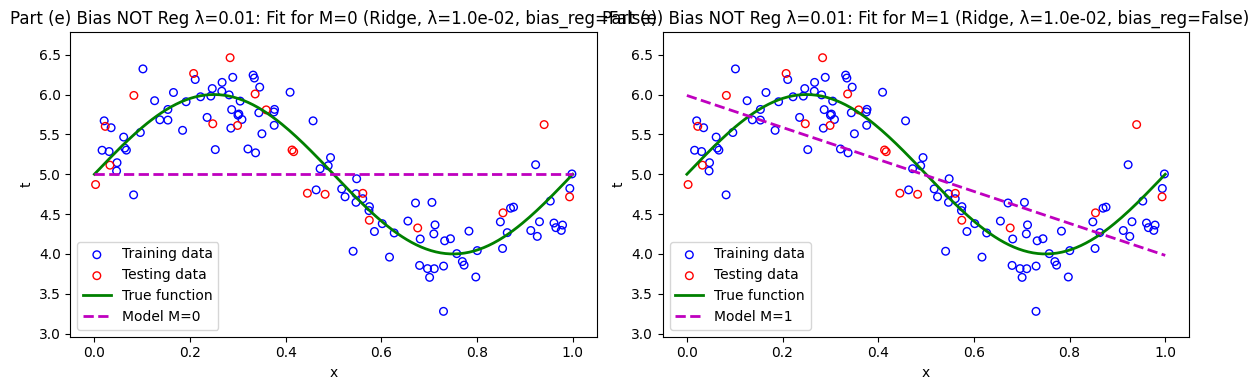

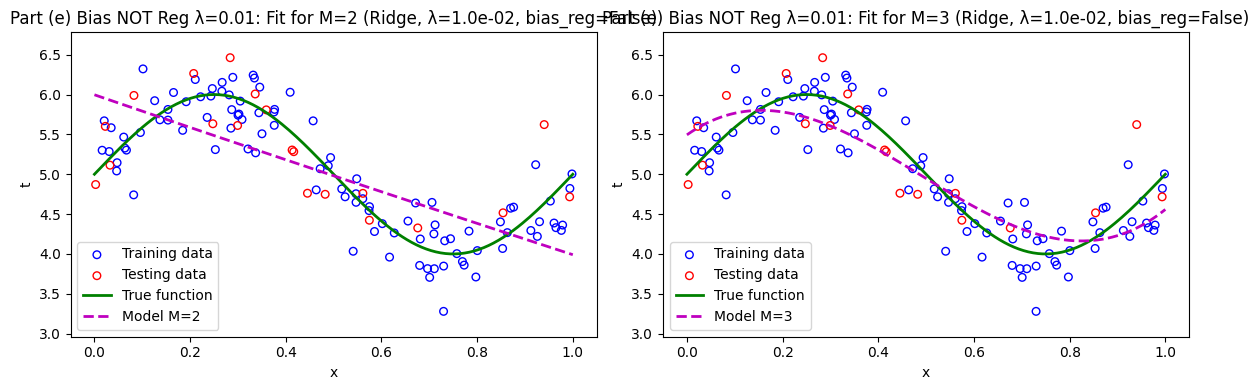

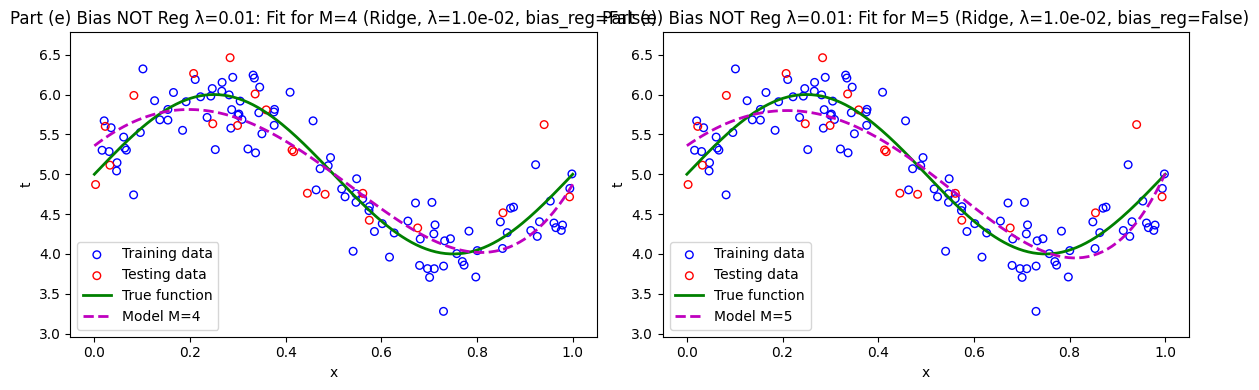

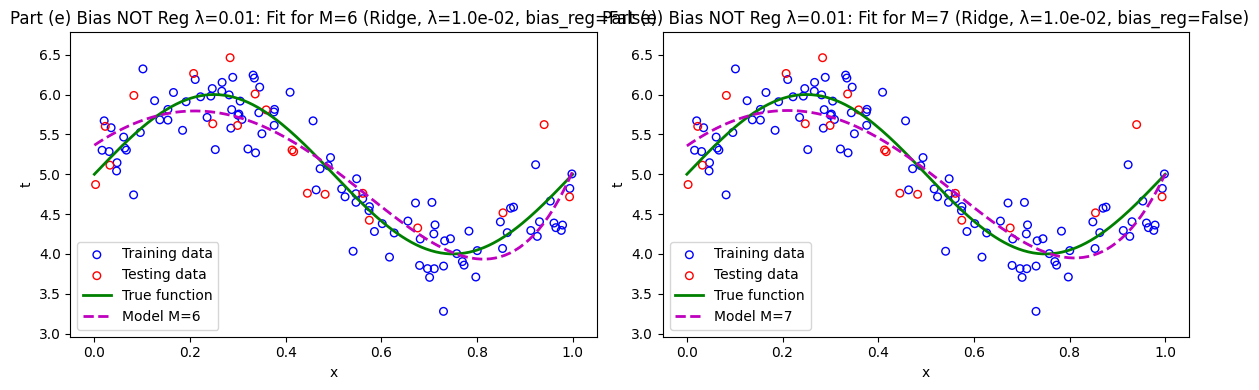

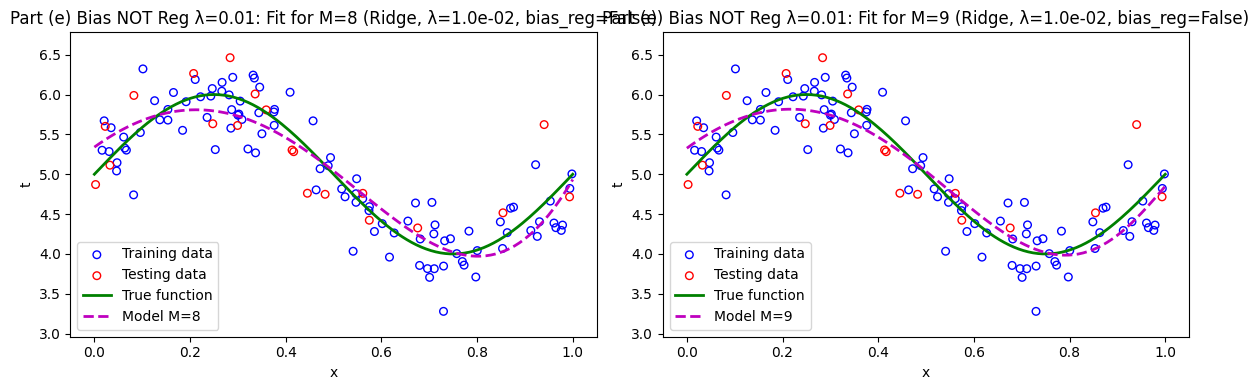

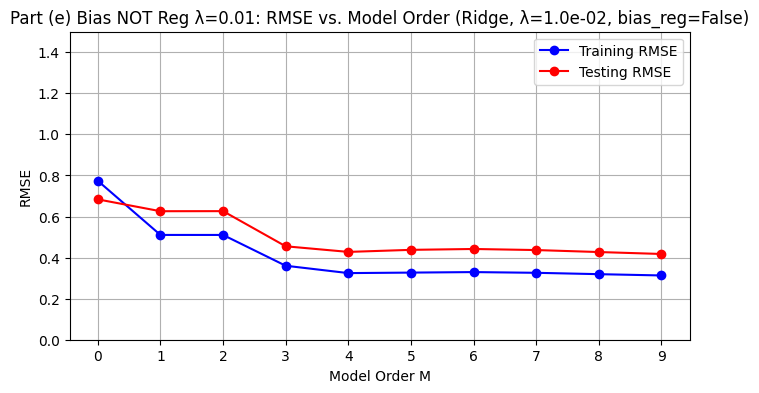


--- Best Model for Part (e) Bias NOT Reg λ=0.01:  ---
Best Model Order M: 9
  - Minimum Test RMSE:  0.4176
  - Train RMSE at M=9: 0.3130
  - Bias w0 at M=9:   5.3268
--- End Best Model Report ---

Analyzing for Part (e) Bias Regularized λ=0.01: :


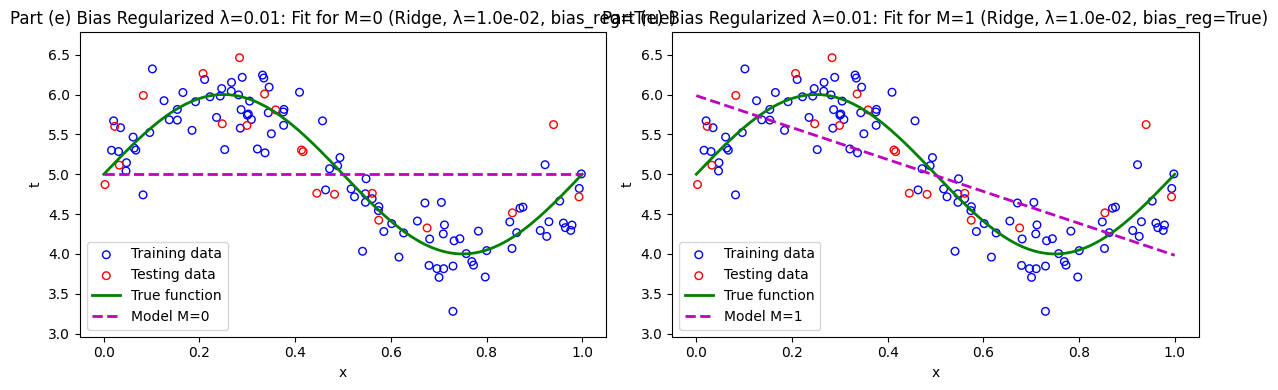

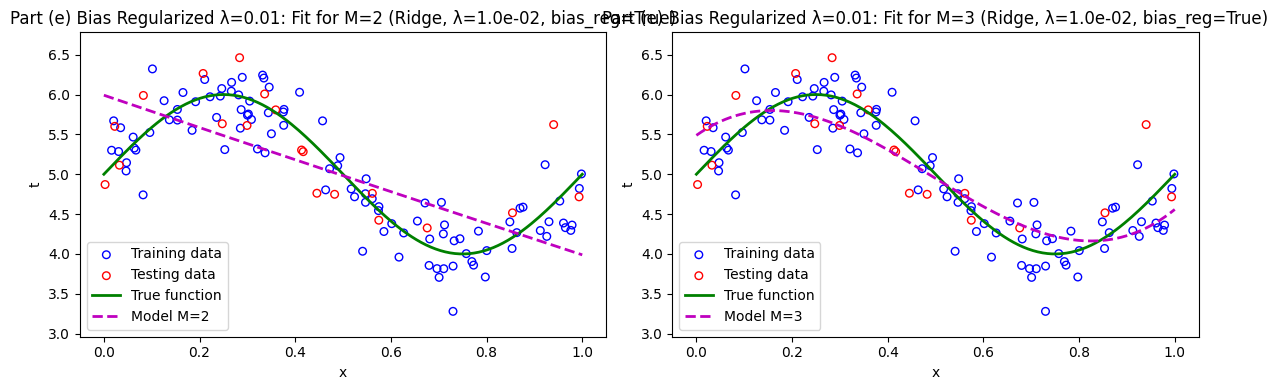

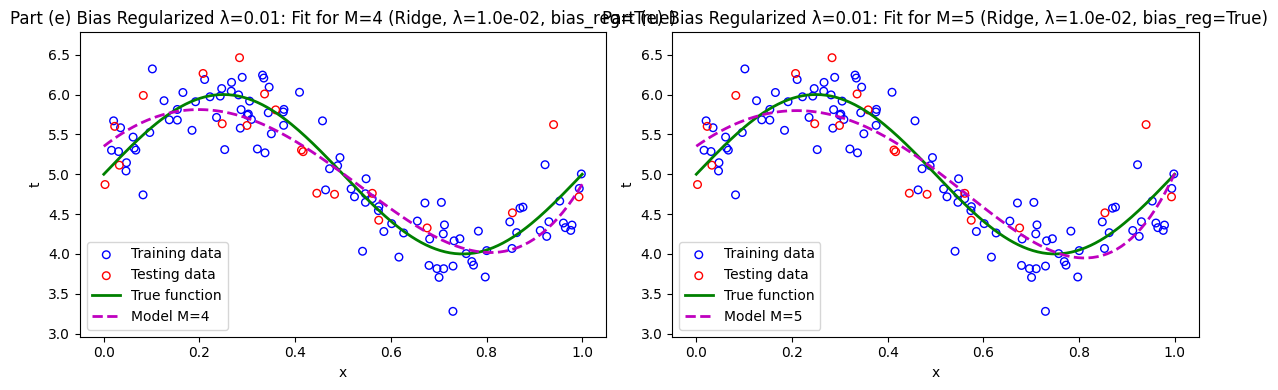

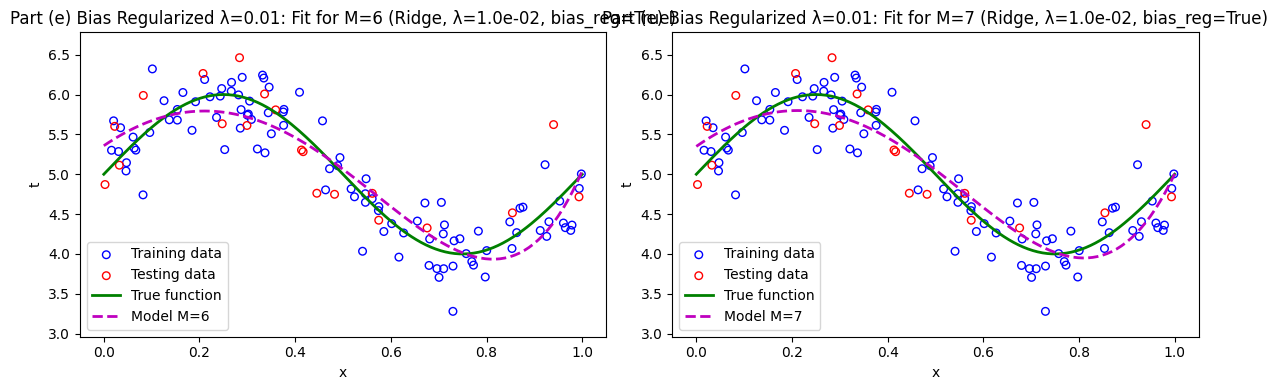

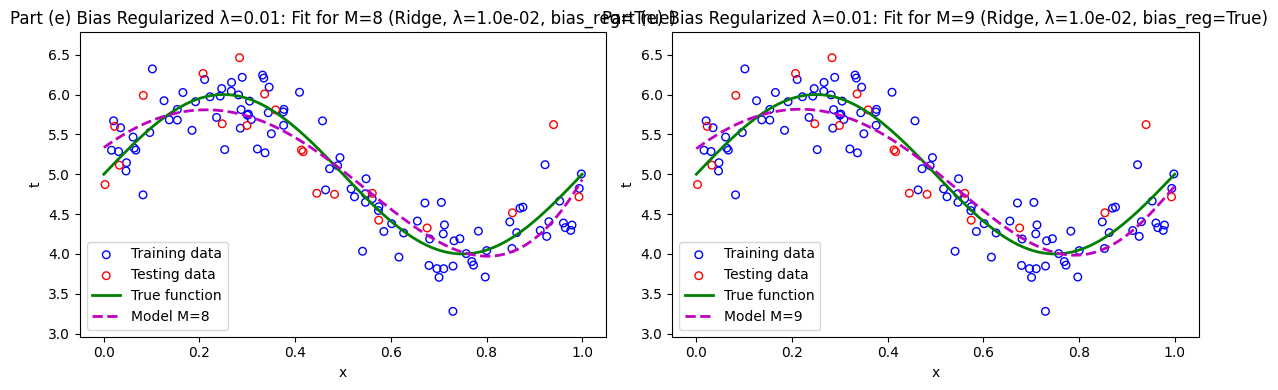

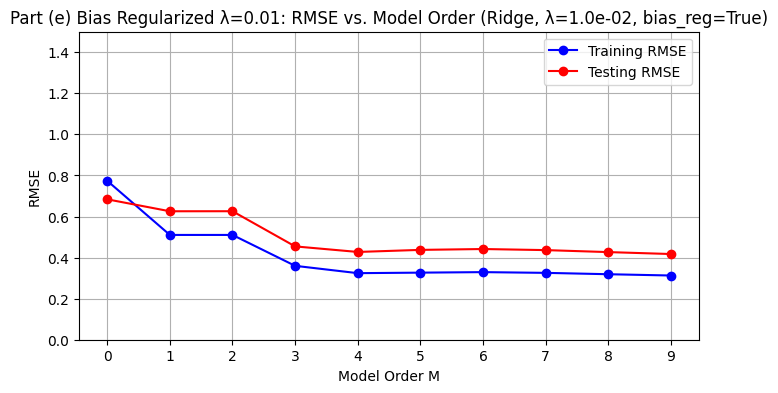


--- Best Model for Part (e) Bias Regularized λ=0.01:  ---
Best Model Order M: 9
  - Minimum Test RMSE:  0.4173
  - Train RMSE at M=9: 0.3127
  - Bias w0 at M=9:   5.3202
--- End Best Model Report ---


In [119]:
# Part (e): Alter function and investigate regularizing bias w0) 
N_train_e = 100
N_test_e = 20
np.random.seed(567)
X_train_e, t_train_e = generate_data_numpy(
    N_train_e, altered_func_np, noise_std=np.sqrt(0.1)
)
X_test_e, t_test_e = generate_data_numpy(
    N_test_e, altered_func_np, noise_std=np.sqrt(0.1)
)
lambda_for_e = 0.01
x_plot_range_e = np.linspace(0, 1, 100).reshape(-1, 1)

# Case 1: Ridge (bias w0 NOT regularized by penalty)
scenario1_title = f"Part (e) Bias NOT Reg λ={lambda_for_e:.2f}: "
print(f"\nAnalyzing for {scenario1_title}:")
Ms_e1, train_rmses_e1, test_rmses_e1, weights_e1 = (
    run_polynomial_regression_experiment_numpy(
        X_train_e,
        t_train_e,
        X_test_e,
        t_test_e,
        max_M=9,
        model_type="ridge",
        ridge_lambda=lambda_for_e,
        regularize_bias=False,
        plot_all_individual_M_fits=True,
        X_full_for_plot=x_plot_range_e,
        func_for_plot=altered_func_np,
        scenario_title_prefix=scenario1_title,
    )
)
best_M_e1, _ = report_best_M(
    Ms_e1, test_rmses_e1, train_rmses_e1, weights_e1, scenario1_title
)

# Case 2: Ridge with Bias (w0) Regularized
scenario2_title = f"Part (e) Bias Regularized λ={lambda_for_e:.2f}: "
print(f"\nAnalyzing for {scenario2_title}:")
Ms_e2, train_rmses_e2, test_rmses_e2, weights_e2 = (
    run_polynomial_regression_experiment_numpy(
        X_train_e,
        t_train_e,
        X_test_e,
        t_test_e,
        max_M=9,
        model_type="ridge",
        ridge_lambda=lambda_for_e,
        regularize_bias=True,
        plot_all_individual_M_fits=True,
        X_full_for_plot=x_plot_range_e,
        func_for_plot=altered_func_np,
        scenario_title_prefix=scenario2_title,
    )
)
best_M_e2, _ = report_best_M(
    Ms_e2, test_rmses_e2, train_rmses_e2, weights_e2, scenario2_title
)


- ```CASE 1``` performs Ridge regression with a fixed lambda, but specifically sets regularize_bias=False. This is the standard approach, where the penalty is not applied to the bias term w0.

- ```CASE 2``` forces the regularization penalty to also apply to the bias term w0.The goal is to compare the results with Case 1 to see the (likely negative) effect of penalizing the bias term, especially when the true function has a large offset that the bias term needs to capture.
